# Spooky Author Identification: Bag-of-Words MLP 34 Model
Note: This model follows test submission 34, in which all unigram and bigram features are considered.

## Implementation

### Import packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '' # '' to run on CPU, '0' to run on the first GPU

In [3]:
# If you don't already have these packages, run this cell
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/greenbeats/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from packages import *

Using TensorFlow backend.


In [5]:
MODEL_NAME = 'bow_mlp_34'

INPUT_DIR = '../input/'
TRAIN_FILE_PATH = f'{INPUT_DIR}train.csv'
TEST_FILE_PATH = f'{INPUT_DIR}test.csv'
SAMPLE_SUBMISSION_FILE_PATH = f'{INPUT_DIR}sample_submission.csv'

IMAGES_DIR = '../images/'
RESULTS_DIR = '../results/'

OUTPUT_DIR = '../output/'
OUTPUT_LOGS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/logs/'
OUTPUT_MODELS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/models/'
OUTPUT_SCORES_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/scores/'
OUTPUT_SUBMISSIONS_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/submissions/'
OUTPUT_SUMMARIES_DIR = f'{OUTPUT_DIR}{MODEL_NAME}/summaries/'

# Create the output directories if they do not exist (the `_` is necessary
# in order to create intermediate directories and is itself not created)
os.makedirs(os.path.dirname(f'{OUTPUT_LOGS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_MODELS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SCORES_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SUBMISSIONS_DIR}_'), exist_ok=True)
os.makedirs(os.path.dirname(f'{OUTPUT_SUMMARIES_DIR}_'), exist_ok=True)

MAX_FEATURES = None # The max number of features (unigrams and bigrams)
TOKEN_MODE = 'word' # Word-level tokenization; can also be set to 'char'
NGRAM_RANGE = (1, 2) # Range of n-gram sizes (unigrams and bigrams)
# A token will be discarded if it appears less than 2 times across documents in the corpus
MIN_DOCUMENT_FREQUENCY = 2
N_SPLITS = 10

# Fix a random seed for reproducibility
SEED = 42
np.random.seed(SEED)

### Load data

In [6]:
train, test, submission = load_data(TRAIN_FILE_PATH,
                                    TEST_FILE_PATH,
                                    SAMPLE_SUBMISSION_FILE_PATH)

### Google's "Algorithm for Data Preparation and Model Building"

Let's follow Google's algorithm below to test our hypothesis that a bag-of-words multilayer perceptron model will perform better than our CNN and RNN models using pre-trained GloVe and fastText word embeddings.

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

```
1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a
simple multi-layer perceptron (MLP) model to classify them (left branch in the
flowchart below):
  a. Split the samples into word n-grams; convert the n-grams into vectors.
  b. Score the importance of the vectors and then select the top 20K using the scores.
  c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a
   sepCNN model to classify them (right branch in the flowchart below):
  a. Split the samples into words; select the top 20K words based on their frequency.
  b. Convert the samples into word sequence vectors.
  c. If the original number of samples/number of words per sample ratio is less
     than 15K, using a fine-tuned pre-trained embedding with the sepCNN
     model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.
```

### Calculate the number of samples/number of words per sample ratio
From the same source URL above, Google has stated the following:

> **From our experiments, we have observed that the ratio of “number of samples” (S) to “number of words per sample” (W) correlates with which model performs well.**

> When the value for this ratio is small (<1500), small multi-layer perceptrons that take n-grams as input (which we'll call **Option A**) perform better or at least as well as sequence models. MLPs are simple to define and understand, and they take much less compute time than sequence models. When the value for this ratio is large (>= 1500), use a sequence model (**Option B**).


We have calculated that this number is about `732.46` from the EDA notebook.

### Tokenize the text as word n-grams and convert them into vectors
Since the calculated ratio of `732.46` is less than the `1500` threshold, we'll proceed with **Option A** (the n-gram inputs with an MLP model). First, we need to tokenize the text as n-grams and select only the top `MAX_FEATURES` most important features from the vector of tokens.

### Preprocess text

In [7]:
# The target classes need to be converted to integers so that
# EAP --> 0
# HPL --> 1
# MWS --> 2
y_train_integers = integer_encode_classes(train['author'].values)

Original class labels: ['EAP' 'HPL' 'MWS']


In [8]:
# The target classes need to be one-hot encoded so that
# EAP --> 0 --> [1, 0, 0]
# HPL --> 1 --> [0, 1, 0]
# MWS --> 2 --> [0, 0, 1]
y_train_encoded = one_hot_encode_classes(y_train_integers)

In [9]:
# Apply text preprocessing on each sentence
X_train_sequences = list(train['text'].apply(
    lambda x: process_text(x,
                           lower=False,
                           remove_punc=False,
                           normalize_spelling=False,
                           stem=False,
                           lemmatize=False,
                           remove_stopwords=False)).values)
X_test_sequences = list(test['text'].apply(
    lambda x: process_text(x,
                           lower=False,
                           remove_punc=False,
                           normalize_spelling=False,
                           stem=False,
                           lemmatize=False,
                           remove_stopwords=False)).values)

# Vectorize the sentences and TF-IDF features
X_train_tokenized, X_test_tokenized = vectorize_ngrams(X_train_sequences,
                                                       X_test_sequences,
                                                       y_train_integers,
                                                       MAX_FEATURES,
                                                       TOKEN_MODE,
                                                       NGRAM_RANGE,
                                                       MIN_DOCUMENT_FREQUENCY)

Found 76318 unique unigrams and bigrams.


In [10]:
# Retrieve the input shape
input_shape = X_train_tokenized.shape[1:]
input_shape

(76318,)

In [11]:
X_train_tokenized[0:3]

<3x76318 sparse matrix of type '<class 'numpy.float64'>'
	with 163 stored elements in Compressed Sparse Row format>

### Train the model
Each model will be evaluated based on the logloss metric using either 5-fold or 10-fold cross validation; the lower the logloss, the better the model. This is the step in which we measure the model performance with different hyperparameter values to find the best model configuration for the dataset.

In [12]:
# Import model-dependent files
from models import build_model_callbacks, save_model_summary
from models import get_random_mlp_params as get_random_model_params
from models import build_mlp_model as build_model

In [21]:
# Random search

training_num_epochs = 100 # With early stopping in place
num_random_search_iter = 60 # The number of iterations
offset_iter = 0 # How many iterations to offset the nth iteration by

# Calculate the k-fold splits (same splits across all iterations)
kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

# Randomly search for the best model using 10-fold cross validation for each iteration.
# Note: Before re-running this cell, you might want to delete the existing files in the
# `OUTPUT_SUMMARIES_DIR` folder, since the files within might not get overwritten.
for nth_iter in range(1+offset_iter, num_random_search_iter+1+offset_iter):
    
    # Start the training timer for the current iteration
    training_start = time()
    
    nth_iter_str = f'iter_{nth_iter:02d}'
    print(f'\n----- Iteration {nth_iter} of {num_random_search_iter+offset_iter} -----')

    # Metrics to monitor and record
    monitored_metric = 'val_loss'
    other_metrics = ['val_acc', 'loss', 'acc']
    all_metrics = ['val_loss', 'val_acc', 'loss', 'acc']
    
    # The number of training epochs that have passed at which
    # the best validation loss is recorded
    best_score_num_epochs = []
    
    # The metric scores recorded from the epoch number at which
    # the best validation loss is recorded.
    # Note that each list should be `N_SPLITS` in length.
    best_scores_per_fold = { 'val_loss': [], 'val_acc': [], 'loss': [], 'acc': [] }
    
    # Runtime records
    pred_runtimes = []
    pred_runtime_strs = []

    # Retrieve the random model params for the current iteration
    random_model_params = get_random_model_params()
    batch_size = random_model_params['batch_size']
    
    print('Writing model params to file...')
    params_file_path = f'{OUTPUT_MODELS_DIR}{nth_iter_str}.params.json'
    save_dictionary_to_file(random_model_params, params_file_path)    
    
    # The model summary, improvement log, and classification summary file path
    log_file_path = f'{OUTPUT_LOGS_DIR}{nth_iter_str}.log.txt'
    
    # Prepare the generator
    folds = kfold.split(X_train_tokenized, y_train_integers)
    
    # Begin 10-fold cross validation for the current set of random model params
    for fold, (train_indices, valid_indices) in enumerate(folds):
        nth_fold = fold + 1
        nth_fold_str = f'fold_{nth_fold:02d}'
        print(f'\n----- Fold {nth_fold} of {N_SPLITS} -----')

        # Prepare the splits of data
        X_train, y_train = X_train_tokenized[train_indices], y_train_encoded[train_indices]
        X_valid, y_valid = X_train_tokenized[valid_indices], y_train_encoded[valid_indices]

        # Construct model callbacks, save the best models, and log metrics to file
        logger_file_path = f'{OUTPUT_SCORES_DIR}{nth_iter_str}.{nth_fold_str}.scores.csv'
        model_callbacks = build_model_callbacks(monitored_metric,
                                                'min',
                                                log_file_path, # progress
                                                None, # model
                                                logger_file_path, # logger
                                                nth_fold,
                                                N_SPLITS)
        # Build the model
        model = build_model(input_shape, random_model_params)
        # Save the model summary to file on the first fold only
        # since the models are identical across folds
        if nth_fold == 1:
            save_model_summary(model, log_file_path)
        
        # Train the model
        history = model.fit(X_train,
                            y_train,
                            batch_size=batch_size,
                            epochs=training_num_epochs,
                            verbose=1,
                            callbacks=model_callbacks,
                            validation_data=[X_valid, y_valid],
                            shuffle=True)
        
        # Save the scores for later evaluation
        monitored_metric_fold_scores = history.history[monitored_metric]
        # Save only the best validation loss
        epoch_index = np.argmin(monitored_metric_fold_scores)
        best_score_num_epochs.append(int(epoch_index + 1))
        best_monitored_metric_score = monitored_metric_fold_scores[epoch_index]
        best_scores_per_fold[monitored_metric].append(best_monitored_metric_score)

        for metric in other_metrics:
            other_metric_fold_scores = history.history[metric]
            # Save only the corresponding current metric score for the
            # best validation loss epoch
            same_epoch_score = other_metric_fold_scores[epoch_index]
            best_scores_per_fold[metric].append(same_epoch_score)

        # Construct a classification report and confusion matrix
        print('Making predictions...')
        pred_start = time()
        y_pred = model.predict(X_valid, batch_size=batch_size, verbose=0)
        pred_elapsed, pred_elapsed_str = get_time_elapsed(pred_start)
        pred_runtimes.append(pred_elapsed)
        pred_runtime_strs.append(pred_elapsed_str)

        print('Writing classification summary to file...')
        save_classification_summary(y_valid,
                                    y_pred,
                                    [0, 1, 2],
                                    ['EAP', 'HPL', 'MWS'],
                                    log_file_path,
                                    mode='a')

    print('Writing CV results and runtime summary to file...')
    # Calculate the mean and standard deviation across all folds' best scores
    summary_lines = 'CV Results Summary:'
    for metric in all_metrics:
        mean = np.mean(best_scores_per_fold[metric])
        std = np.std(best_scores_per_fold[metric])
        summary_lines += f'\n- {metric} mean and std: {mean:.5f} (+/- {std:.5f})'
    monitored_mean = np.mean(best_scores_per_fold[monitored_metric])
    summary_file_path = (f'{OUTPUT_SUMMARIES_DIR}{monitored_mean:.5f}.'
                         f'{nth_iter_str}.summary.txt')
    
    # Calculate the suggested number of epochs to train for
    # using the entire training dataset
    final_num_epochs = np.mean(best_score_num_epochs)
    # We take the ceiling because it's better to train for
    # a little longer than to underfit
    final_num_epochs = int(np.ceil(final_num_epochs))
    summary_lines += f'\n\nfinal_num_epochs = {final_num_epochs}\n\n'
    
    # Save the best epochs per fold
    best_epochs_str = json.dumps(best_score_num_epochs)
    summary_lines += f'best_score_num_epochs = {best_epochs_str}\n\n'
    
    # Save the best scores per fold
    best_scores_str = json.dumps(best_scores_per_fold, indent=4)
    summary_lines += f'best_scores_per_fold = {best_scores_str}\n\n'
    
    # Calculate the total and average runtimes across all folds
    training_elapsed, training_elapsed_str = get_time_elapsed(training_start)
    training_fold_elapsed_str = format_time_str(training_elapsed / N_SPLITS)
    pred_elapsed = np.sum(pred_runtimes)
    pred_elapsed_str = format_time_str(pred_elapsed)
    pred_fold_elapsed_str = format_time_str(pred_elapsed / N_SPLITS)
    summary_lines += (f'Total stratified {N_SPLITS}-fold loop runtime: '
                      f'{training_elapsed_str}\n'
                      f'Average training runtime per fold: '
                      f'{training_fold_elapsed_str}\n\n'
                      f'Total stratified {N_SPLITS}-fold prediction runtime: '
                      f'{pred_elapsed_str}\n'
                      f'Average prediction runtime per fold: '
                      f'{pred_fold_elapsed_str}\n')
    for f, time_str in enumerate(pred_runtime_strs):
        summary_lines += f'\nFold {f + 1} prediction runtime: {time_str}'
    
    save_line_to_file(summary_lines, summary_file_path, 'w')



----- Iteration 1 of 60 -----
Writing model params to file...

----- Fold 1 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 7s 382us/step - loss: 0.8576 - acc: 0.6886 - val_loss: 0.6392 - val_acc: 0.8111
Epoch 2/100
17620/17620 [==============================] - 6s 351us/step - loss: 0.4458 - acc: 0.8756 - val_loss: 0.4441 - val_acc: 0.8423
Epoch 3/100
17620/17620 [==============================] - 6s 348us/step - loss: 0.2622 - acc: 0.9205 - val_loss: 0.3751 - val_acc: 0.8596
Epoch 4/100
17620/17620 [==============================] - 6s 348us/step - loss: 0.1736 - acc: 0.9435 - val_loss: 0.3451 - val_acc: 0.8606
Epoch 5/100
17620/17620 [==============================] - 6s 348us/step - loss: 0.1279 - acc: 0.9583 - val_loss: 0.3374 - val_acc: 0.8652
Epoch 6/100
17620/17620 [==============================] - 6s 349us/step - loss: 0.0932 - acc: 0.9713 - val_loss: 0.3362 - val_acc: 0.8637
Epoch 7/100
17620/17620 [===

Epoch 2/100
17622/17622 [==============================] - 6s 352us/step - loss: 0.4322 - acc: 0.8794 - val_loss: 0.4320 - val_acc: 0.8487
Epoch 3/100
17622/17622 [==============================] - 6s 353us/step - loss: 0.2585 - acc: 0.9226 - val_loss: 0.3578 - val_acc: 0.8625
Epoch 4/100
17622/17622 [==============================] - 6s 350us/step - loss: 0.1715 - acc: 0.9459 - val_loss: 0.3286 - val_acc: 0.8723
Epoch 5/100
17622/17622 [==============================] - 6s 350us/step - loss: 0.1260 - acc: 0.9600 - val_loss: 0.3204 - val_acc: 0.8774
Epoch 6/100
17622/17622 [==============================] - 6s 351us/step - loss: 0.0908 - acc: 0.9711 - val_loss: 0.3248 - val_acc: 0.8799
Epoch 7/100
17622/17622 [==============================] - 6s 351us/step - loss: 0.0703 - acc: 0.9777 - val_loss: 0.3279 - val_acc: 0.8830
Epoch 8/100
17622/17622 [==============================] - 6s 352us/step - loss: 0.0579 - acc: 0.9806 - val_loss: 0.3332 - val_acc: 0.8809
Epoch 00008: early stopping

17620/17620 [==============================] - 6s 334us/step - loss: 0.9735 - acc: 0.5081 - val_loss: 0.7045 - val_acc: 0.7948
Epoch 2/100
17620/17620 [==============================] - 5s 305us/step - loss: 0.3351 - acc: 0.9265 - val_loss: 0.3249 - val_acc: 0.8826
Epoch 3/100
17620/17620 [==============================] - 5s 305us/step - loss: 0.0639 - acc: 0.9867 - val_loss: 0.3081 - val_acc: 0.8831
Epoch 4/100
17620/17620 [==============================] - 5s 306us/step - loss: 0.0191 - acc: 0.9977 - val_loss: 0.3142 - val_acc: 0.8867
Epoch 5/100
17620/17620 [==============================] - 5s 306us/step - loss: 0.0095 - acc: 0.9991 - val_loss: 0.3229 - val_acc: 0.8841
Epoch 6/100
17620/17620 [==============================] - 5s 306us/step - loss: 0.0054 - acc: 0.9997 - val_loss: 0.3294 - val_acc: 0.8846
Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100

Epoch 00008: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 2 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 5s 306us/step - loss: 0.9210 - acc: 0.5873 - val_loss: 0.6158 - val_acc: 0.8178
Epoch 2/100
17620/17620 [==============================] - 5s 288us/step - loss: 0.5074 - acc: 0.8185 - val_loss: 0.3847 - val_acc: 0.8601
Epoch 3/100
17620/17620 [==============================] - 5s 290us/step - loss: 0.3265 - acc: 0.8817 - val_loss: 0.3348 - val_acc: 0.8657
Epoch 4/100
17620/17620 [==============================] - 5s 291us/step - loss: 0.2438 - acc: 0.9136 - val_loss: 0.3194 - val_acc: 0.8749
Epoch 5/100
17620/17620 [==============================] - 5s 287us/step - loss: 0.1970 - acc: 0.9281 - val_loss: 0.3226 - val_acc: 0.8806
Epoch 6/100
17620/17620 [==============================] - 5s 288us/step - loss: 0.1689 - acc: 0.9413 - val_loss: 0.3165 - val_acc: 0.8841

17620/17620 [==============================] - 5s 312us/step - loss: 0.0771 - acc: 0.9787 - val_loss: 0.2954 - val_acc: 0.8816
Epoch 15/100
17620/17620 [==============================] - 5s 312us/step - loss: 0.0640 - acc: 0.9833 - val_loss: 0.2967 - val_acc: 0.8857
Epoch 16/100
17620/17620 [==============================] - 6s 313us/step - loss: 0.0555 - acc: 0.9847 - val_loss: 0.2993 - val_acc: 0.8841
Epoch 17/100
17620/17620 [==============================] - 5s 311us/step - loss: 0.0505 - acc: 0.9855 - val_loss: 0.3008 - val_acc: 0.8857
Epoch 00017: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 3 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 6s 325us/step - loss: 1.0250 - acc: 0.5072 - val_loss: 0.9500 - val_acc: 0.6325
Epoch 2/100
17620/17620 [==============================] - 6s 313us/step - loss: 0.8375 - acc: 0.7564 - val_loss: 0.7962 - val_acc: 0.7688
Epoch 3/

17622/17622 [==============================] - 6s 331us/step - loss: 1.0168 - acc: 0.5539 - val_loss: 0.9288 - val_acc: 0.7236
Epoch 2/100
17622/17622 [==============================] - 6s 313us/step - loss: 0.8149 - acc: 0.8100 - val_loss: 0.7602 - val_acc: 0.8191
Epoch 3/100
17622/17622 [==============================] - 6s 313us/step - loss: 0.6276 - acc: 0.8685 - val_loss: 0.6213 - val_acc: 0.8355
Epoch 4/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.4793 - acc: 0.8932 - val_loss: 0.5214 - val_acc: 0.8533
Epoch 5/100
17622/17622 [==============================] - 6s 313us/step - loss: 0.3727 - acc: 0.9139 - val_loss: 0.4533 - val_acc: 0.8585
Epoch 6/100
17622/17622 [==============================] - 6s 314us/step - loss: 0.2983 - acc: 0.9261 - val_loss: 0.4066 - val_acc: 0.8605
Epoch 7/100
17622/17622 [==============================] - 6s 314us/step - loss: 0.2380 - acc: 0.9383 - val_loss: 0.3754 - val_acc: 0.8661
Epoch 8/100
17622/17622 [==============

Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 7s 400us/step - loss: 0.7365 - acc: 0.7124 - val_loss: 0.3946 - val_acc: 0.8764
Epoch 2/100
17621/17621 [==============================] - 6s 352us/step - loss: 0.2028 - acc: 0.9436 - val_loss: 0.3068 - val_acc: 0.8963
Epoch 3/100
17621/17621 [==============================] - 6s 351us/step - loss: 0.0663 - acc: 0.9879 - val_loss: 0.2995 - val_acc: 0.8938
Epoch 4/100
17621/17621 [==============================] - 6s 352us/step - loss: 0.0316 - acc: 0.9960 - val_loss: 0.3149 - val_acc: 0.8876
Epoch 5/100
17621/17621 [==============================] - 6s 354us/step - loss: 0.0186 - acc: 0.9974 - val_loss: 0.3194 - val_acc: 0.8882
Epoch 6/100
17621/17621 [==============================] - 6s 351us/step - loss: 0.0131 - acc: 0.9983 - val_loss: 0.3265 - val_acc: 0.8846
Epoch 00006: early stopping
Making predictions...

Epoch 7/100
17620/17620 [==============================] - 6s 339us/step - loss: 0.0686 - acc: 0.9762 - val_loss: 0.3195 - val_acc: 0.8775
Epoch 8/100
17620/17620 [==============================] - 6s 340us/step - loss: 0.0559 - acc: 0.9805 - val_loss: 0.3286 - val_acc: 0.8770
Epoch 00008: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 3 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 6s 356us/step - loss: 0.8371 - acc: 0.7238 - val_loss: 0.5977 - val_acc: 0.8096
Epoch 2/100
17620/17620 [==============================] - 6s 340us/step - loss: 0.3911 - acc: 0.8844 - val_loss: 0.4043 - val_acc: 0.8484
Epoch 3/100
17620/17620 [==============================] - 6s 335us/step - loss: 0.2277 - acc: 0.9277 - val_loss: 0.3458 - val_acc: 0.8617
Epoch 4/100
17620/17620 [==============================] - 6s 340us/step - loss: 0.1542 - acc: 0.9498 - val_loss: 0.3239 - val_acc: 0.8688

17622/17622 [==============================] - 10s 545us/step - loss: 0.0338 - acc: 0.9888 - val_loss: 0.5583 - val_acc: 0.8717
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 9 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 10s 580us/step - loss: 0.5282 - acc: 0.7811 - val_loss: 0.3595 - val_acc: 0.8661
Epoch 2/100
17622/17622 [==============================] - 10s 547us/step - loss: 0.1708 - acc: 0.9389 - val_loss: 0.3481 - val_acc: 0.8702
Epoch 3/100
17622/17622 [==============================] - 10s 552us/step - loss: 0.0968 - acc: 0.9667 - val_loss: 0.4434 - val_acc: 0.8615
Epoch 4/100
17622/17622 [==============================] - 10s 548us/step - loss: 0.0608 - acc: 0.9799 - val_loss: 0.4341 - val_acc: 0.8738
Epoch 5/100
17622/17622 [==============================] - 10s 547us/step - loss: 0.0391 - acc: 0.9866 - val_loss: 0.5696 - val_acc: 0.8712
Epoch

Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 6s 352us/step - loss: 0.9590 - acc: 0.5428 - val_loss: 0.6677 - val_acc: 0.8284
Epoch 2/100
17621/17621 [==============================] - 6s 330us/step - loss: 0.5686 - acc: 0.7892 - val_loss: 0.4020 - val_acc: 0.8621
Epoch 3/100
17621/17621 [==============================] - 6s 329us/step - loss: 0.3806 - acc: 0.8614 - val_loss: 0.3338 - val_acc: 0.8759
Epoch 4/100
17621/17621 [==============================] - 6s 331us/step - loss: 0.2918 - acc: 0.8925 - val_loss: 0.3128 - val_acc: 0.8805
Epoch 5/100
17621/17621 [==============================] - 6s 333us/step - loss: 0.2404 - acc: 0.9114 - val_loss: 0.3106 - val_acc: 0.8861
Epoch 6/100
17621/17621 [==============================] - 6s 331us/step - loss: 0.2005 - acc: 0.9268 - val_loss: 0.3091 - val_acc: 0.8861

Epoch 9/100
17622/17622 [==============================] - 6s 331us/step - loss: 0.1458 - acc: 0.9476 - val_loss: 0.3134 - val_acc: 0.8753
Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...
Writing CV results and runtime summary to file...

----- Iteration 9 of 60 -----
Writing model params to file...

----- Fold 1 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 6s 336us/step - loss: 0.9958 - acc: 0.5071 - val_loss: 0.8002 - val_acc: 0.7764
Epoch 2/100
17620/17620 [==============================] - 6s 318us/step - loss: 0.4814 - acc: 0.8948 - val_loss: 0.4187 - val_acc: 0.8494
Epoch 3/100
17620/17620 [==============================] - 6s 316us/step - loss: 0.1621 - acc: 0.9649 - val_loss: 0.3466 - val_acc: 0.8612
Epoch 4/100
17620/17620 [==============================] - 6s 316us/step - loss: 0.0638 - acc: 0.9911 - val_loss: 0.3356 - val_acc: 0.8673
Epoch 5/100
17620/17620 [

Epoch 6/100
17622/17622 [==============================] - 6s 316us/step - loss: 0.0209 - acc: 0.9981 - val_loss: 0.3452 - val_acc: 0.8723
Epoch 7/100
17622/17622 [==============================] - 6s 317us/step - loss: 0.0142 - acc: 0.9986 - val_loss: 0.3550 - val_acc: 0.8748
Epoch 00007: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 8 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 338us/step - loss: 1.0019 - acc: 0.5341 - val_loss: 0.8052 - val_acc: 0.7404
Epoch 2/100
17622/17622 [==============================] - 6s 316us/step - loss: 0.5007 - acc: 0.8812 - val_loss: 0.4090 - val_acc: 0.8646
Epoch 3/100
17622/17622 [==============================] - 6s 317us/step - loss: 0.1650 - acc: 0.9657 - val_loss: 0.3192 - val_acc: 0.8784
Epoch 4/100
17622/17622 [==============================] - 6s 316us/step - loss: 0.0648 - acc: 0.9904 - val_loss: 0.3079 - val_acc: 0.8794

17620/17620 [==============================] - 6s 349us/step - loss: 0.3145 - acc: 0.8841 - val_loss: 0.3438 - val_acc: 0.8709
Epoch 3/100
17620/17620 [==============================] - 6s 348us/step - loss: 0.1831 - acc: 0.9331 - val_loss: 0.3393 - val_acc: 0.8678
Epoch 4/100
17620/17620 [==============================] - 6s 347us/step - loss: 0.1287 - acc: 0.9523 - val_loss: 0.3490 - val_acc: 0.8668
Epoch 5/100
17620/17620 [==============================] - 6s 350us/step - loss: 0.0963 - acc: 0.9642 - val_loss: 0.3652 - val_acc: 0.8657
Epoch 6/100
17620/17620 [==============================] - 6s 350us/step - loss: 0.0829 - acc: 0.9701 - val_loss: 0.3784 - val_acc: 0.8673
Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 4 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 7s 380us/step - loss: 0.7382 - acc: 0.6748 - val_loss: 0.4356 - val_acc: 0.8469
Epoch 2/100

17621/17621 [==============================] - 5s 277us/step - loss: 0.0968 - acc: 0.9877 - val_loss: 0.3047 - val_acc: 0.8953
Epoch 7/100
17621/17621 [==============================] - 5s 277us/step - loss: 0.0717 - acc: 0.9921 - val_loss: 0.2982 - val_acc: 0.8963
Epoch 8/100
17621/17621 [==============================] - 5s 277us/step - loss: 0.0552 - acc: 0.9938 - val_loss: 0.2980 - val_acc: 0.8917
Epoch 9/100
17621/17621 [==============================] - 5s 277us/step - loss: 0.0438 - acc: 0.9955 - val_loss: 0.2977 - val_acc: 0.8907
Epoch 10/100
17621/17621 [==============================] - 5s 276us/step - loss: 0.0361 - acc: 0.9963 - val_loss: 0.2988 - val_acc: 0.8933
Epoch 11/100
17621/17621 [==============================] - 5s 277us/step - loss: 0.0305 - acc: 0.9972 - val_loss: 0.3003 - val_acc: 0.8887
Epoch 12/100
17621/17621 [==============================] - 5s 276us/step - loss: 0.0259 - acc: 0.9972 - val_loss: 0.3002 - val_acc: 0.8876
Epoch 00012: early stopping
Making p

Writing classification summary to file...

----- Fold 10 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 5s 298us/step - loss: 0.9713 - acc: 0.5922 - val_loss: 0.7833 - val_acc: 0.8094
Epoch 2/100
17622/17622 [==============================] - 5s 277us/step - loss: 0.5708 - acc: 0.8754 - val_loss: 0.5025 - val_acc: 0.8595
Epoch 3/100
17622/17622 [==============================] - 5s 277us/step - loss: 0.3186 - acc: 0.9359 - val_loss: 0.3899 - val_acc: 0.8717
Epoch 4/100
17622/17622 [==============================] - 5s 276us/step - loss: 0.1957 - acc: 0.9642 - val_loss: 0.3407 - val_acc: 0.8804
Epoch 5/100
17622/17622 [==============================] - 5s 278us/step - loss: 0.1294 - acc: 0.9796 - val_loss: 0.3136 - val_acc: 0.8815
Epoch 6/100
17622/17622 [==============================] - 5s 279us/step - loss: 0.0924 - acc: 0.9879 - val_loss: 0.3019 - val_acc: 0.8835
Epoch 7/100
17622/17622 [=======================

17620/17620 [==============================] - 5s 296us/step - loss: 0.0930 - acc: 0.9768 - val_loss: 0.3022 - val_acc: 0.8821
Epoch 22/100
17620/17620 [==============================] - 5s 298us/step - loss: 0.0885 - acc: 0.9777 - val_loss: 0.3009 - val_acc: 0.8795
Epoch 23/100
17620/17620 [==============================] - 5s 296us/step - loss: 0.0880 - acc: 0.9780 - val_loss: 0.3010 - val_acc: 0.8795
Epoch 24/100
17620/17620 [==============================] - 5s 295us/step - loss: 0.0797 - acc: 0.9800 - val_loss: 0.3014 - val_acc: 0.8800
Epoch 25/100
17620/17620 [==============================] - 5s 296us/step - loss: 0.0789 - acc: 0.9796 - val_loss: 0.2994 - val_acc: 0.8806
Epoch 26/100
17620/17620 [==============================] - 5s 297us/step - loss: 0.0744 - acc: 0.9803 - val_loss: 0.3007 - val_acc: 0.8811
Epoch 27/100
17620/17620 [==============================] - 5s 296us/step - loss: 0.0703 - acc: 0.9826 - val_loss: 0.3003 - val_acc: 0.8800
Epoch 28/100
17620/17620 [=======

17622/17622 [==============================] - 5s 295us/step - loss: 0.5887 - acc: 0.8498 - val_loss: 0.6016 - val_acc: 0.8441
Epoch 5/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.4749 - acc: 0.8805 - val_loss: 0.5237 - val_acc: 0.8631
Epoch 6/100
17622/17622 [==============================] - 5s 297us/step - loss: 0.3978 - acc: 0.8976 - val_loss: 0.4681 - val_acc: 0.8687
Epoch 7/100
17622/17622 [==============================] - 5s 296us/step - loss: 0.3363 - acc: 0.9149 - val_loss: 0.4285 - val_acc: 0.8774
Epoch 8/100
17622/17622 [==============================] - 5s 297us/step - loss: 0.2883 - acc: 0.9308 - val_loss: 0.3992 - val_acc: 0.8774
Epoch 9/100
17622/17622 [==============================] - 5s 297us/step - loss: 0.2571 - acc: 0.9363 - val_loss: 0.3785 - val_acc: 0.8763
Epoch 10/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.2221 - acc: 0.9454 - val_loss: 0.3605 - val_acc: 0.8820
Epoch 11/100
17622/17622 [============

17620/17620 [==============================] - 9s 507us/step - loss: 0.1550 - acc: 0.9426 - val_loss: 0.4088 - val_acc: 0.8520
Epoch 3/100
17620/17620 [==============================] - 9s 510us/step - loss: 0.0546 - acc: 0.9815 - val_loss: 0.4469 - val_acc: 0.8627
Epoch 4/100
17620/17620 [==============================] - 9s 506us/step - loss: 0.0243 - acc: 0.9918 - val_loss: 0.5066 - val_acc: 0.8576
Epoch 00004: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 2 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 10s 557us/step - loss: 0.6173 - acc: 0.7284 - val_loss: 0.3420 - val_acc: 0.8693
Epoch 2/100
17620/17620 [==============================] - 9s 507us/step - loss: 0.1549 - acc: 0.9452 - val_loss: 0.3250 - val_acc: 0.8770
Epoch 3/100
17620/17620 [==============================] - 9s 503us/step - loss: 0.0522 - acc: 0.9831 - val_loss: 0.3818 - val_acc: 0.8785
Epoch 4/10

17622/17622 [==============================] - 8s 464us/step - loss: 0.0354 - acc: 0.9880 - val_loss: 0.3694 - val_acc: 0.8840
Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 10 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 9s 492us/step - loss: 0.6477 - acc: 0.7546 - val_loss: 0.3783 - val_acc: 0.8523
Epoch 2/100
17622/17622 [==============================] - 8s 464us/step - loss: 0.2204 - acc: 0.9247 - val_loss: 0.3070 - val_acc: 0.8743
Epoch 3/100
17622/17622 [==============================] - 8s 462us/step - loss: 0.1206 - acc: 0.9578 - val_loss: 0.3089 - val_acc: 0.8733
Epoch 4/100
17622/17622 [==============================] - 8s 463us/step - loss: 0.0777 - acc: 0.9733 - val_loss: 0.3158 - val_acc: 0.8784
Epoch 5/100
17622/17622 [==============================] - 8s 463us/step - loss: 0.0526 - acc: 0.9804 - val_loss: 0.3369 - val_acc: 0.8769
Epoch 0000

Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 7s 374us/step - loss: 0.7750 - acc: 0.6562 - val_loss: 0.4428 - val_acc: 0.8390
Epoch 2/100
17622/17622 [==============================] - 6s 345us/step - loss: 0.3295 - acc: 0.8771 - val_loss: 0.3700 - val_acc: 0.8564
Epoch 3/100
17622/17622 [==============================] - 6s 347us/step - loss: 0.1988 - acc: 0.9267 - val_loss: 0.3743 - val_acc: 0.8528
Epoch 4/100
17622/17622 [==============================] - 6s 346us/step - loss: 0.1346 - acc: 0.9522 - val_loss: 0.3616 - val_acc: 0.8738
Epoch 5/100
17622/17622 [==============================] - 6s 345us/step - loss: 0.1039 - acc: 0.9623 - val_loss: 0.3805 - val_acc: 0.8723
Epoch 6/100
17622/17622 [==============================] - 6s 343us/step - loss: 0.0841 - acc: 0.9692 - val_loss: 0.3847 - val_acc: 0.8738
Epoch 7/100
17622/17622 [==============================] - 6s 346us/step - loss: 0.0659 - acc: 0.9749 - val_loss: 0.4

17620/17620 [==============================] - 11s 606us/step - loss: 0.2282 - acc: 0.9153 - val_loss: 0.3349 - val_acc: 0.8765
Epoch 3/100
17620/17620 [==============================] - 11s 607us/step - loss: 0.1112 - acc: 0.9601 - val_loss: 0.3659 - val_acc: 0.8683
Epoch 4/100
17620/17620 [==============================] - 11s 605us/step - loss: 0.0668 - acc: 0.9770 - val_loss: 0.3768 - val_acc: 0.8693
Epoch 5/100
17620/17620 [==============================] - 11s 610us/step - loss: 0.0514 - acc: 0.9802 - val_loss: 0.4207 - val_acc: 0.8688
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 12s 655us/step - loss: 0.6616 - acc: 0.7083 - val_loss: 0.3447 - val_acc: 0.8723
Epoch 2/100
17621/17621 [==============================] - 11s 613us/step - loss: 0.2379 - acc: 0.9133 - val_loss: 0.3172 - val_acc: 0.8805
Epoch

17620/17620 [==============================] - 6s 313us/step - loss: 0.2521 - acc: 0.9417 - val_loss: 0.3837 - val_acc: 0.8795
Epoch 8/100
17620/17620 [==============================] - 6s 314us/step - loss: 0.2093 - acc: 0.9547 - val_loss: 0.3629 - val_acc: 0.8806
Epoch 9/100
17620/17620 [==============================] - 5s 312us/step - loss: 0.1836 - acc: 0.9602 - val_loss: 0.3480 - val_acc: 0.8846
Epoch 10/100
17620/17620 [==============================] - 6s 313us/step - loss: 0.1581 - acc: 0.9662 - val_loss: 0.3351 - val_acc: 0.8867
Epoch 11/100
17620/17620 [==============================] - 5s 312us/step - loss: 0.1398 - acc: 0.9700 - val_loss: 0.3275 - val_acc: 0.8857
Epoch 12/100
17620/17620 [==============================] - 5s 312us/step - loss: 0.1247 - acc: 0.9732 - val_loss: 0.3217 - val_acc: 0.8851
Epoch 13/100
17620/17620 [==============================] - 5s 312us/step - loss: 0.1119 - acc: 0.9759 - val_loss: 0.3160 - val_acc: 0.8841
Epoch 14/100
17620/17620 [=========

Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 331us/step - loss: 1.0447 - acc: 0.4831 - val_loss: 0.9647 - val_acc: 0.6433
Epoch 2/100
17622/17622 [==============================] - 6s 313us/step - loss: 0.8399 - acc: 0.7636 - val_loss: 0.7717 - val_acc: 0.8125
Epoch 3/100
17622/17622 [==============================] - 6s 314us/step - loss: 0.6231 - acc: 0.8522 - val_loss: 0.6164 - val_acc: 0.8365
Epoch 4/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.4704 - acc: 0.8868 - val_loss: 0.5179 - val_acc: 0.8533
Epoch 5/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.3652 - acc: 0.9154 - val_loss: 0.4561 - val_acc: 0.8636
Epoch 6/100
17622/17622 [==============================] - 6s 314us/step - loss: 0.2972 - acc: 0.9302 - val_loss: 0.4169 - val_acc: 0.8631
Epoch 7/100
17622/17622 [==============================] - 6s 314us/step - loss: 0.2457 - acc: 0.9444 - val_loss: 0.3

Epoch 16/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.0850 - acc: 0.9829 - val_loss: 0.3013 - val_acc: 0.8830
Epoch 17/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.0783 - acc: 0.9839 - val_loss: 0.3033 - val_acc: 0.8815
Epoch 18/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.0721 - acc: 0.9858 - val_loss: 0.3027 - val_acc: 0.8815
Epoch 19/100
17622/17622 [==============================] - 6s 313us/step - loss: 0.0669 - acc: 0.9863 - val_loss: 0.3017 - val_acc: 0.8820
Epoch 00019: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 10 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 330us/step - loss: 1.0477 - acc: 0.4679 - val_loss: 0.9677 - val_acc: 0.6316
Epoch 2/100
17622/17622 [==============================] - 6s 312us/step - loss: 0.8574 - acc: 0.7512 - val_loss: 0.7758 - val_acc: 0

17620/17620 [==============================] - 5s 293us/step - loss: 0.5024 - acc: 0.9456 - val_loss: 0.5883 - val_acc: 0.8622
Epoch 5/100
17620/17620 [==============================] - 5s 293us/step - loss: 0.3758 - acc: 0.9628 - val_loss: 0.5102 - val_acc: 0.8698
Epoch 6/100
17620/17620 [==============================] - 5s 294us/step - loss: 0.2868 - acc: 0.9717 - val_loss: 0.4564 - val_acc: 0.8749
Epoch 7/100
17620/17620 [==============================] - 5s 292us/step - loss: 0.2233 - acc: 0.9791 - val_loss: 0.4196 - val_acc: 0.8770
Epoch 8/100
17620/17620 [==============================] - 5s 293us/step - loss: 0.1789 - acc: 0.9835 - val_loss: 0.3927 - val_acc: 0.8811
Epoch 9/100
17620/17620 [==============================] - 5s 291us/step - loss: 0.1441 - acc: 0.9890 - val_loss: 0.3723 - val_acc: 0.8841
Epoch 10/100
17620/17620 [==============================] - 5s 293us/step - loss: 0.1186 - acc: 0.9924 - val_loss: 0.3577 - val_acc: 0.8862
Epoch 11/100
17620/17620 [============

17622/17622 [==============================] - 5s 292us/step - loss: 0.0616 - acc: 0.9973 - val_loss: 0.3188 - val_acc: 0.8784
Epoch 15/100
17622/17622 [==============================] - 5s 294us/step - loss: 0.0534 - acc: 0.9981 - val_loss: 0.3143 - val_acc: 0.8799
Epoch 16/100
17622/17622 [==============================] - 5s 292us/step - loss: 0.0469 - acc: 0.9988 - val_loss: 0.3106 - val_acc: 0.8799
Epoch 17/100
17622/17622 [==============================] - 5s 292us/step - loss: 0.0411 - acc: 0.9986 - val_loss: 0.3083 - val_acc: 0.8799
Epoch 18/100
17622/17622 [==============================] - 5s 292us/step - loss: 0.0363 - acc: 0.9991 - val_loss: 0.3064 - val_acc: 0.8820
Epoch 19/100
17622/17622 [==============================] - 5s 294us/step - loss: 0.0329 - acc: 0.9989 - val_loss: 0.3051 - val_acc: 0.8804
Epoch 20/100
17622/17622 [==============================] - 5s 293us/step - loss: 0.0297 - acc: 0.9993 - val_loss: 0.3041 - val_acc: 0.8799
Epoch 21/100
17622/17622 [=======

17622/17622 [==============================] - 6s 359us/step - loss: 0.1608 - acc: 0.9427 - val_loss: 0.3537 - val_acc: 0.8774
Epoch 3/100
17622/17622 [==============================] - 6s 366us/step - loss: 0.0638 - acc: 0.9785 - val_loss: 0.3850 - val_acc: 0.8758
Epoch 4/100
17622/17622 [==============================] - 6s 353us/step - loss: 0.0270 - acc: 0.9906 - val_loss: 0.4575 - val_acc: 0.8753
Epoch 5/100
17622/17622 [==============================] - 6s 355us/step - loss: 0.0128 - acc: 0.9957 - val_loss: 0.5409 - val_acc: 0.8641
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 8 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 7s 392us/step - loss: 0.6238 - acc: 0.7473 - val_loss: 0.3578 - val_acc: 0.8605
Epoch 2/100
17622/17622 [==============================] - 6s 361us/step - loss: 0.1640 - acc: 0.9437 - val_loss: 0.3559 - val_acc: 0.8595
Epoch 3/100

Epoch 5/100
17620/17620 [==============================] - 6s 331us/step - loss: 0.1082 - acc: 0.9892 - val_loss: 0.3438 - val_acc: 0.8760
Epoch 6/100
17620/17620 [==============================] - 6s 331us/step - loss: 0.0724 - acc: 0.9954 - val_loss: 0.3299 - val_acc: 0.8760
Epoch 7/100
17620/17620 [==============================] - 6s 333us/step - loss: 0.0513 - acc: 0.9974 - val_loss: 0.3226 - val_acc: 0.8734
Epoch 8/100
17620/17620 [==============================] - 6s 333us/step - loss: 0.0381 - acc: 0.9987 - val_loss: 0.3193 - val_acc: 0.8739
Epoch 9/100
17620/17620 [==============================] - 6s 332us/step - loss: 0.0290 - acc: 0.9989 - val_loss: 0.3163 - val_acc: 0.8729
Epoch 10/100
17620/17620 [==============================] - 6s 332us/step - loss: 0.0232 - acc: 0.9993 - val_loss: 0.3142 - val_acc: 0.8754
Epoch 11/100
17620/17620 [==============================] - 6s 333us/step - loss: 0.0188 - acc: 0.9995 - val_loss: 0.3149 - val_acc: 0.8734
Epoch 12/100
17620/17620 

17622/17622 [==============================] - 6s 324us/step - loss: 0.1056 - acc: 0.9909 - val_loss: 0.3491 - val_acc: 0.8702
Epoch 6/100
17622/17622 [==============================] - 6s 326us/step - loss: 0.0707 - acc: 0.9952 - val_loss: 0.3385 - val_acc: 0.8702
Epoch 7/100
17622/17622 [==============================] - 6s 322us/step - loss: 0.0497 - acc: 0.9976 - val_loss: 0.3333 - val_acc: 0.8743
Epoch 8/100
17622/17622 [==============================] - 6s 323us/step - loss: 0.0370 - acc: 0.9984 - val_loss: 0.3310 - val_acc: 0.8738
Epoch 9/100
17622/17622 [==============================] - 6s 324us/step - loss: 0.0283 - acc: 0.9990 - val_loss: 0.3310 - val_acc: 0.8697
Epoch 10/100
17622/17622 [==============================] - 6s 325us/step - loss: 0.0225 - acc: 0.9993 - val_loss: 0.3311 - val_acc: 0.8712
Epoch 11/100
17622/17622 [==============================] - 6s 325us/step - loss: 0.0186 - acc: 0.9995 - val_loss: 0.3325 - val_acc: 0.8738
Epoch 12/100
17622/17622 [===========

17620/17620 [==============================] - 5s 304us/step - loss: 0.6760 - acc: 0.8150 - val_loss: 0.6771 - val_acc: 0.8224
Epoch 5/100
17620/17620 [==============================] - 5s 304us/step - loss: 0.5852 - acc: 0.8328 - val_loss: 0.6033 - val_acc: 0.8341
Epoch 6/100
17620/17620 [==============================] - 5s 303us/step - loss: 0.5126 - acc: 0.8515 - val_loss: 0.5466 - val_acc: 0.8326
Epoch 7/100
17620/17620 [==============================] - 5s 303us/step - loss: 0.4535 - acc: 0.8659 - val_loss: 0.4994 - val_acc: 0.8453
Epoch 8/100
17620/17620 [==============================] - 5s 304us/step - loss: 0.4064 - acc: 0.8766 - val_loss: 0.4620 - val_acc: 0.8504
Epoch 9/100
17620/17620 [==============================] - 5s 305us/step - loss: 0.3605 - acc: 0.8923 - val_loss: 0.4304 - val_acc: 0.8586
Epoch 10/100
17620/17620 [==============================] - 5s 305us/step - loss: 0.3314 - acc: 0.8957 - val_loss: 0.4073 - val_acc: 0.8581
Epoch 11/100
17620/17620 [============

17622/17622 [==============================] - 5s 305us/step - loss: 0.1418 - acc: 0.9528 - val_loss: 0.3255 - val_acc: 0.8794
Epoch 24/100
17622/17622 [==============================] - 5s 306us/step - loss: 0.1334 - acc: 0.9540 - val_loss: 0.3252 - val_acc: 0.8799
Epoch 00024: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 7 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 321us/step - loss: 1.0414 - acc: 0.4959 - val_loss: 0.9806 - val_acc: 0.5805
Epoch 2/100
17622/17622 [==============================] - 5s 305us/step - loss: 0.9088 - acc: 0.6984 - val_loss: 0.8707 - val_acc: 0.7394
Epoch 3/100
17622/17622 [==============================] - 5s 305us/step - loss: 0.7865 - acc: 0.7709 - val_loss: 0.7663 - val_acc: 0.7864
Epoch 4/100
17622/17622 [==============================] - 5s 305us/step - loss: 0.6779 - acc: 0.8087 - val_loss: 0.6771 - val_acc: 0.8145
Epoch 5/10

17622/17622 [==============================] - 5s 302us/step - loss: 0.1244 - acc: 0.9576 - val_loss: 0.2828 - val_acc: 0.8866
Epoch 28/100
17622/17622 [==============================] - 5s 302us/step - loss: 0.1204 - acc: 0.9602 - val_loss: 0.2828 - val_acc: 0.8855
Epoch 29/100
17622/17622 [==============================] - 5s 300us/step - loss: 0.1170 - acc: 0.9589 - val_loss: 0.2829 - val_acc: 0.8845
Epoch 00029: early stopping
Making predictions...
Writing classification summary to file...
Writing CV results and runtime summary to file...

----- Iteration 25 of 60 -----
Writing model params to file...

----- Fold 1 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 12s 703us/step - loss: 0.6486 - acc: 0.7170 - val_loss: 0.3937 - val_acc: 0.8453
Epoch 2/100
17620/17620 [==============================] - 12s 656us/step - loss: 0.2273 - acc: 0.9157 - val_loss: 0.3617 - val_acc: 0.8632
Epoch 3/100
17620/17620 [=======

17622/17622 [==============================] - 12s 663us/step - loss: 0.0511 - acc: 0.9813 - val_loss: 0.4150 - val_acc: 0.8625
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 10 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 13s 711us/step - loss: 0.6514 - acc: 0.7122 - val_loss: 0.3518 - val_acc: 0.8620
Epoch 2/100
17622/17622 [==============================] - 12s 662us/step - loss: 0.2303 - acc: 0.9131 - val_loss: 0.3195 - val_acc: 0.8677
Epoch 3/100
17622/17622 [==============================] - 12s 659us/step - loss: 0.1130 - acc: 0.9604 - val_loss: 0.3530 - val_acc: 0.8610
Epoch 4/100
17622/17622 [==============================] - 12s 663us/step - loss: 0.0690 - acc: 0.9746 - val_loss: 0.3848 - val_acc: 0.8646
Epoch 5/100
17622/17622 [==============================] - 12s 662us/step - loss: 0.0468 - acc: 0.9836 - val_loss: 0.4037 - val_acc: 0.8671
Epoc

Epoch 5/100
17621/17621 [==============================] - 6s 353us/step - loss: 0.1837 - acc: 0.9404 - val_loss: 0.3029 - val_acc: 0.8912
Epoch 6/100
17621/17621 [==============================] - 6s 349us/step - loss: 0.1528 - acc: 0.9526 - val_loss: 0.2968 - val_acc: 0.8882
Epoch 7/100
17621/17621 [==============================] - 6s 349us/step - loss: 0.1265 - acc: 0.9598 - val_loss: 0.3060 - val_acc: 0.8866
Epoch 8/100
17621/17621 [==============================] - 6s 351us/step - loss: 0.1089 - acc: 0.9640 - val_loss: 0.3016 - val_acc: 0.8917
Epoch 9/100
17621/17621 [==============================] - 6s 349us/step - loss: 0.0949 - acc: 0.9705 - val_loss: 0.3022 - val_acc: 0.8922
Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 6 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 7s 374us/step - loss: 0.9301 - acc: 0.5911 - val_loss: 0.6629 - val_acc: 0.8166

Epoch 5/100
17622/17622 [==============================] - 6s 352us/step - loss: 0.1859 - acc: 0.9397 - val_loss: 0.2962 - val_acc: 0.8845
Epoch 6/100
17622/17622 [==============================] - 6s 353us/step - loss: 0.1539 - acc: 0.9503 - val_loss: 0.2888 - val_acc: 0.8871
Epoch 7/100
17622/17622 [==============================] - 6s 352us/step - loss: 0.1292 - acc: 0.9581 - val_loss: 0.2884 - val_acc: 0.8830
Epoch 8/100
17622/17622 [==============================] - 6s 352us/step - loss: 0.1148 - acc: 0.9618 - val_loss: 0.2877 - val_acc: 0.8866
Epoch 9/100
17622/17622 [==============================] - 6s 351us/step - loss: 0.1001 - acc: 0.9673 - val_loss: 0.2860 - val_acc: 0.8896
Epoch 10/100
17622/17622 [==============================] - 6s 351us/step - loss: 0.0883 - acc: 0.9709 - val_loss: 0.2900 - val_acc: 0.8906
Epoch 11/100
17622/17622 [==============================] - 6s 352us/step - loss: 0.0826 - acc: 0.9734 - val_loss: 0.2941 - val_acc: 0.8855
Epoch 12/100
17622/17622 

Epoch 00008: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 4 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 5s 293us/step - loss: 0.9400 - acc: 0.5886 - val_loss: 0.6969 - val_acc: 0.8040
Epoch 2/100
17620/17620 [==============================] - 5s 277us/step - loss: 0.4848 - acc: 0.8530 - val_loss: 0.4067 - val_acc: 0.8586
Epoch 3/100
17620/17620 [==============================] - 5s 274us/step - loss: 0.2617 - acc: 0.9123 - val_loss: 0.3390 - val_acc: 0.8739
Epoch 4/100
17620/17620 [==============================] - 5s 276us/step - loss: 0.1673 - acc: 0.9440 - val_loss: 0.3208 - val_acc: 0.8790
Epoch 5/100
17620/17620 [==============================] - 5s 278us/step - loss: 0.1101 - acc: 0.9648 - val_loss: 0.3217 - val_acc: 0.8862
Epoch 6/100
17620/17620 [==============================] - 5s 276us/step - loss: 0.0812 - acc: 0.9729 - val_loss: 0.3303 - val_acc: 0.8877

Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 11s 652us/step - loss: 0.7325 - acc: 0.6711 - val_loss: 0.4128 - val_acc: 0.8377
Epoch 2/100
17620/17620 [==============================] - 11s 608us/step - loss: 0.3355 - acc: 0.8730 - val_loss: 0.3678 - val_acc: 0.8509
Epoch 3/100
17620/17620 [==============================] - 11s 601us/step - loss: 0.2039 - acc: 0.9232 - val_loss: 0.3538 - val_acc: 0.8586
Epoch 4/100
17620/17620 [==============================] - 11s 607us/step - loss: 0.1386 - acc: 0.9495 - val_loss: 0.3674 - val_acc: 0.8555
Epoch 5/100
17620/17620 [==============================] - 11s 603us/step - loss: 0.1049 - acc: 0.9622 - val_loss: 0.3920 - val_acc: 0.8612
Epoch 6/100
17620/17620 [==============================] - 11s 605us/step - loss: 0.0904 - acc: 0.9671 - val_loss: 0.3789 - val_acc: 0.8637
Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 2 of 10

Epoch 7/100
17622/17622 [==============================] - 11s 602us/step - loss: 0.0771 - acc: 0.9732 - val_loss: 0.3518 - val_acc: 0.8763
Epoch 00007: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 9 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 11s 649us/step - loss: 0.7268 - acc: 0.6734 - val_loss: 0.4052 - val_acc: 0.8467
Epoch 2/100
17622/17622 [==============================] - 11s 604us/step - loss: 0.3319 - acc: 0.8742 - val_loss: 0.3475 - val_acc: 0.8636
Epoch 3/100
17622/17622 [==============================] - 11s 605us/step - loss: 0.2084 - acc: 0.9221 - val_loss: 0.3405 - val_acc: 0.8702
Epoch 4/100
17622/17622 [==============================] - 11s 602us/step - loss: 0.1413 - acc: 0.9468 - val_loss: 0.3438 - val_acc: 0.8682
Epoch 5/100
17622/17622 [==============================] - 11s 609us/step - loss: 0.1113 - acc: 0.9602 - val_loss: 0.3473 - val_acc: 

17621/17621 [==============================] - 5s 292us/step - loss: 0.5442 - acc: 0.7929 - val_loss: 0.3634 - val_acc: 0.8749
Epoch 3/100
17621/17621 [==============================] - 5s 292us/step - loss: 0.3319 - acc: 0.8817 - val_loss: 0.3096 - val_acc: 0.8897
Epoch 4/100
17621/17621 [==============================] - 5s 292us/step - loss: 0.2408 - acc: 0.9146 - val_loss: 0.2950 - val_acc: 0.8922
Epoch 5/100
17621/17621 [==============================] - 5s 291us/step - loss: 0.1812 - acc: 0.9356 - val_loss: 0.2979 - val_acc: 0.8922
Epoch 6/100
17621/17621 [==============================] - 5s 293us/step - loss: 0.1443 - acc: 0.9473 - val_loss: 0.3112 - val_acc: 0.8912
Epoch 7/100
17621/17621 [==============================] - 5s 292us/step - loss: 0.1270 - acc: 0.9577 - val_loss: 0.3224 - val_acc: 0.8856
Epoch 00007: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 6 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100

Epoch 9/100
17620/17620 [==============================] - 5s 309us/step - loss: 0.0317 - acc: 0.9936 - val_loss: 0.3448 - val_acc: 0.8668
Epoch 10/100
17620/17620 [==============================] - 5s 307us/step - loss: 0.0229 - acc: 0.9948 - val_loss: 0.3514 - val_acc: 0.8688
Epoch 00010: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 2 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 6s 333us/step - loss: 0.9064 - acc: 0.6804 - val_loss: 0.7225 - val_acc: 0.8367
Epoch 2/100
17620/17620 [==============================] - 5s 307us/step - loss: 0.5240 - acc: 0.8952 - val_loss: 0.5050 - val_acc: 0.8576
Epoch 3/100
17620/17620 [==============================] - 5s 308us/step - loss: 0.3171 - acc: 0.9314 - val_loss: 0.3937 - val_acc: 0.8749
Epoch 4/100
17620/17620 [==============================] - 5s 310us/step - loss: 0.2013 - acc: 0.9536 - val_loss: 0.3360 - val_acc: 0.882

17622/17622 [==============================] - 6s 338us/step - loss: 0.9050 - acc: 0.6995 - val_loss: 0.7235 - val_acc: 0.8222
Epoch 2/100
17622/17622 [==============================] - 5s 310us/step - loss: 0.5207 - acc: 0.8953 - val_loss: 0.5170 - val_acc: 0.8477
Epoch 3/100
17622/17622 [==============================] - 5s 312us/step - loss: 0.3139 - acc: 0.9345 - val_loss: 0.4116 - val_acc: 0.8574
Epoch 4/100
17622/17622 [==============================] - 5s 311us/step - loss: 0.1989 - acc: 0.9574 - val_loss: 0.3570 - val_acc: 0.8697
Epoch 5/100
17622/17622 [==============================] - 5s 311us/step - loss: 0.1311 - acc: 0.9709 - val_loss: 0.3304 - val_acc: 0.8758
Epoch 6/100
17622/17622 [==============================] - 5s 312us/step - loss: 0.0889 - acc: 0.9799 - val_loss: 0.3195 - val_acc: 0.8779
Epoch 7/100
17622/17622 [==============================] - 5s 310us/step - loss: 0.0619 - acc: 0.9862 - val_loss: 0.3169 - val_acc: 0.8815
Epoch 8/100
17622/17622 [==============

Epoch 4/100
17622/17622 [==============================] - 7s 377us/step - loss: 0.2784 - acc: 0.8980 - val_loss: 0.3797 - val_acc: 0.8452
Epoch 5/100
17622/17622 [==============================] - 7s 376us/step - loss: 0.2324 - acc: 0.9162 - val_loss: 0.3733 - val_acc: 0.8533
Epoch 6/100
17622/17622 [==============================] - 7s 377us/step - loss: 0.2061 - acc: 0.9249 - val_loss: 0.3634 - val_acc: 0.8595
Epoch 7/100
17622/17622 [==============================] - 7s 377us/step - loss: 0.1857 - acc: 0.9338 - val_loss: 0.3640 - val_acc: 0.8620
Epoch 8/100
17622/17622 [==============================] - 7s 379us/step - loss: 0.1704 - acc: 0.9407 - val_loss: 0.3636 - val_acc: 0.8712
Epoch 9/100
17622/17622 [==============================] - 7s 378us/step - loss: 0.1512 - acc: 0.9478 - val_loss: 0.3647 - val_acc: 0.8682
Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 8 of 10 -----
Train on 17622 samples, validate on 1957 samples

17620/17620 [==============================] - 5s 289us/step - loss: 0.5875 - acc: 0.8537 - val_loss: 0.6285 - val_acc: 0.8259
Epoch 7/100
17620/17620 [==============================] - 5s 289us/step - loss: 0.5221 - acc: 0.8691 - val_loss: 0.5777 - val_acc: 0.8310
Epoch 8/100
17620/17620 [==============================] - 5s 290us/step - loss: 0.4670 - acc: 0.8796 - val_loss: 0.5358 - val_acc: 0.8382
Epoch 9/100
17620/17620 [==============================] - 5s 289us/step - loss: 0.4247 - acc: 0.8896 - val_loss: 0.4998 - val_acc: 0.8423
Epoch 10/100
17620/17620 [==============================] - 5s 291us/step - loss: 0.3793 - acc: 0.8992 - val_loss: 0.4700 - val_acc: 0.8453
Epoch 11/100
17620/17620 [==============================] - 5s 288us/step - loss: 0.3483 - acc: 0.9046 - val_loss: 0.4440 - val_acc: 0.8515
Epoch 12/100
17620/17620 [==============================] - 5s 291us/step - loss: 0.3175 - acc: 0.9133 - val_loss: 0.4211 - val_acc: 0.8571
Epoch 13/100
17620/17620 [==========

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 5s 303us/step - loss: 1.0506 - acc: 0.5462 - val_loss: 0.9954 - val_acc: 0.6129
Epoch 2/100
17621/17621 [==============================] - 5s 289us/step - loss: 0.9393 - acc: 0.7025 - val_loss: 0.9003 - val_acc: 0.7457
Epoch 3/100
17621/17621 [==============================] - 5s 290us/step - loss: 0.8317 - acc: 0.7746 - val_loss: 0.8078 - val_acc: 0.8054
Epoch 4/100
17621/17621 [==============================] - 5s 292us/step - loss: 0.7316 - acc: 0.8155 - val_loss: 0.7228 - val_acc: 0.8412
Epoch 5/100
17621/17621 [==============================] - 5s 291us/step - loss: 0.6432 - acc: 0.8416 - val_loss: 0.6489 - val_acc: 0.8509
Epoch 6/100
17621/17621 [==============================] - 5s 291us/step - loss: 0.5678 - acc: 0.8547 - val_loss: 0.5864 - val_acc: 0.8682
Epoch 7/100
17621/17621 [==============================] - 5s 291us/step - loss: 0.5047 - acc: 0.8741 - val_loss: 0.5

17622/17622 [==============================] - 5s 290us/step - loss: 0.1098 - acc: 0.9679 - val_loss: 0.2966 - val_acc: 0.8804
Epoch 28/100
17622/17622 [==============================] - 5s 291us/step - loss: 0.1085 - acc: 0.9654 - val_loss: 0.2966 - val_acc: 0.8799
Epoch 29/100
17622/17622 [==============================] - 5s 291us/step - loss: 0.1009 - acc: 0.9688 - val_loss: 0.2970 - val_acc: 0.8804
Epoch 30/100
17622/17622 [==============================] - 5s 292us/step - loss: 0.0954 - acc: 0.9719 - val_loss: 0.2982 - val_acc: 0.8825
Epoch 31/100
17622/17622 [==============================] - 5s 292us/step - loss: 0.0905 - acc: 0.9712 - val_loss: 0.3003 - val_acc: 0.8820
Epoch 00031: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 9 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 5s 310us/step - loss: 1.0518 - acc: 0.5049 - val_loss: 1.0025 - val_acc: 0.5912
Epoch 2

17621/17621 [==============================] - 6s 353us/step - loss: 0.1100 - acc: 0.9698 - val_loss: 0.3012 - val_acc: 0.8912
Epoch 6/100
17621/17621 [==============================] - 6s 345us/step - loss: 0.0814 - acc: 0.9788 - val_loss: 0.3033 - val_acc: 0.8922
Epoch 7/100
17621/17621 [==============================] - 6s 351us/step - loss: 0.0688 - acc: 0.9803 - val_loss: 0.3038 - val_acc: 0.8876
Epoch 8/100
17621/17621 [==============================] - 6s 353us/step - loss: 0.0555 - acc: 0.9852 - val_loss: 0.3093 - val_acc: 0.8830
Epoch 00008: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 6 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 7s 377us/step - loss: 0.8726 - acc: 0.6315 - val_loss: 0.5770 - val_acc: 0.8426
Epoch 2/100
17622/17622 [==============================] - 6s 351us/step - loss: 0.4203 - acc: 0.8683 - val_loss: 0.3939 - val_acc: 0.8682
Epoch 3/100

Epoch 2/100
17620/17620 [==============================] - 6s 339us/step - loss: 0.1802 - acc: 0.9359 - val_loss: 0.3221 - val_acc: 0.8709
Epoch 3/100
17620/17620 [==============================] - 6s 342us/step - loss: 0.0695 - acc: 0.9759 - val_loss: 0.3455 - val_acc: 0.8770
Epoch 4/100
17620/17620 [==============================] - 6s 343us/step - loss: 0.0347 - acc: 0.9886 - val_loss: 0.3807 - val_acc: 0.8785
Epoch 5/100
17620/17620 [==============================] - 6s 343us/step - loss: 0.0215 - acc: 0.9929 - val_loss: 0.4167 - val_acc: 0.8765
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 3 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 7s 371us/step - loss: 0.6430 - acc: 0.7333 - val_loss: 0.3653 - val_acc: 0.8617
Epoch 2/100
17620/17620 [==============================] - 6s 344us/step - loss: 0.1735 - acc: 0.9405 - val_loss: 0.3314 - val_acc: 0.8698

17622/17622 [==============================] - 6s 350us/step - loss: 0.2021 - acc: 0.9437 - val_loss: 0.3254 - val_acc: 0.8697
Epoch 4/100
17622/17622 [==============================] - 6s 350us/step - loss: 0.1215 - acc: 0.9639 - val_loss: 0.3037 - val_acc: 0.8794
Epoch 5/100
17622/17622 [==============================] - 6s 347us/step - loss: 0.0762 - acc: 0.9779 - val_loss: 0.2970 - val_acc: 0.8815
Epoch 6/100
17622/17622 [==============================] - 6s 348us/step - loss: 0.0520 - acc: 0.9847 - val_loss: 0.3045 - val_acc: 0.8855
Epoch 7/100
17622/17622 [==============================] - 6s 350us/step - loss: 0.0370 - acc: 0.9893 - val_loss: 0.3142 - val_acc: 0.8840
Epoch 8/100
17622/17622 [==============================] - 6s 347us/step - loss: 0.0273 - acc: 0.9922 - val_loss: 0.3277 - val_acc: 0.8804
Epoch 00008: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 9 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100

Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 4 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 7s 405us/step - loss: 0.8950 - acc: 0.6486 - val_loss: 0.6188 - val_acc: 0.8356
Epoch 2/100
17620/17620 [==============================] - 6s 358us/step - loss: 0.3724 - acc: 0.9053 - val_loss: 0.3864 - val_acc: 0.8688
Epoch 3/100
17620/17620 [==============================] - 6s 357us/step - loss: 0.1732 - acc: 0.9574 - val_loss: 0.3312 - val_acc: 0.8749
Epoch 4/100
17620/17620 [==============================] - 6s 357us/step - loss: 0.0954 - acc: 0.9805 - val_loss: 0.3164 - val_acc: 0.8826
Epoch 5/100
17620/17620 [==============================] - 6s 360us/step - loss: 0.0616 - acc: 0.9890 - val_loss: 0.3075 - val_acc: 0.8831
Epoch 6/100
17620/17620 [==============================] - 6s 357us/step - loss: 0.0416 - acc: 0.9927 - val_loss: 0.3093 - val_acc: 0.8836

Epoch 5/100
17622/17622 [==============================] - 9s 538us/step - loss: 0.1122 - acc: 0.9615 - val_loss: 0.3673 - val_acc: 0.8753
Epoch 6/100
17622/17622 [==============================] - 9s 534us/step - loss: 0.0980 - acc: 0.9636 - val_loss: 0.3707 - val_acc: 0.8769
Epoch 7/100
17622/17622 [==============================] - 9s 532us/step - loss: 0.0814 - acc: 0.9719 - val_loss: 0.3864 - val_acc: 0.8753
Epoch 00007: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 8 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 10s 561us/step - loss: 0.6681 - acc: 0.7395 - val_loss: 0.4178 - val_acc: 0.8350
Epoch 2/100
17622/17622 [==============================] - 9s 536us/step - loss: 0.2865 - acc: 0.8936 - val_loss: 0.3418 - val_acc: 0.8666
Epoch 3/100
17622/17622 [==============================] - 9s 534us/step - loss: 0.1939 - acc: 0.9299 - val_loss: 0.3278 - val_acc: 0.869

17620/17620 [==============================] - 6s 337us/step - loss: 0.1615 - acc: 0.9447 - val_loss: 0.3417 - val_acc: 0.8703
Epoch 6/100
17620/17620 [==============================] - 6s 342us/step - loss: 0.1329 - acc: 0.9545 - val_loss: 0.3377 - val_acc: 0.8749
Epoch 7/100
17620/17620 [==============================] - 6s 339us/step - loss: 0.1110 - acc: 0.9608 - val_loss: 0.3436 - val_acc: 0.8754
Epoch 8/100
17620/17620 [==============================] - 6s 340us/step - loss: 0.0973 - acc: 0.9670 - val_loss: 0.3495 - val_acc: 0.8734
Epoch 9/100
17620/17620 [==============================] - 6s 342us/step - loss: 0.0849 - acc: 0.9706 - val_loss: 0.3466 - val_acc: 0.8790
Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 6s 359us/step - loss: 0.8531 - acc: 0.6540 - val_loss: 0.5909 - val_acc: 0.8248
Epoch 2/100

Epoch 7/100
17622/17622 [==============================] - 6s 337us/step - loss: 0.1118 - acc: 0.9608 - val_loss: 0.3166 - val_acc: 0.8743
Epoch 8/100
17622/17622 [==============================] - 6s 341us/step - loss: 0.0970 - acc: 0.9661 - val_loss: 0.3209 - val_acc: 0.8809
Epoch 9/100
17622/17622 [==============================] - 6s 340us/step - loss: 0.0854 - acc: 0.9696 - val_loss: 0.3238 - val_acc: 0.8789
Epoch 00009: early stopping
Making predictions...
Writing classification summary to file...
Writing CV results and runtime summary to file...

----- Iteration 43 of 60 -----
Writing model params to file...

----- Fold 1 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 6s 322us/step - loss: 1.0619 - acc: 0.4439 - val_loss: 0.9663 - val_acc: 0.5620
Epoch 2/100
17620/17620 [==============================] - 5s 294us/step - loss: 0.7906 - acc: 0.7214 - val_loss: 0.6097 - val_acc: 0.8218
Epoch 3/100
17620/17620 

Epoch 2/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.8376 - acc: 0.6887 - val_loss: 0.6303 - val_acc: 0.8237
Epoch 3/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.4448 - acc: 0.8699 - val_loss: 0.3942 - val_acc: 0.8605
Epoch 4/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.2434 - acc: 0.9268 - val_loss: 0.3421 - val_acc: 0.8733
Epoch 5/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.1563 - acc: 0.9539 - val_loss: 0.3276 - val_acc: 0.8804
Epoch 6/100
17622/17622 [==============================] - 5s 296us/step - loss: 0.1147 - acc: 0.9661 - val_loss: 0.3261 - val_acc: 0.8763
Epoch 7/100
17622/17622 [==============================] - 5s 295us/step - loss: 0.0869 - acc: 0.9745 - val_loss: 0.3334 - val_acc: 0.8748
Epoch 8/100
17622/17622 [==============================] - 5s 294us/step - loss: 0.0680 - acc: 0.9795 - val_loss: 0.3459 - val_acc: 0.8758
Epoch 9/100
17622/17622 [==

17621/17621 [==============================] - 5s 288us/step - loss: 0.1200 - acc: 0.9660 - val_loss: 0.2936 - val_acc: 0.8948
Epoch 10/100
17621/17621 [==============================] - 5s 288us/step - loss: 0.1032 - acc: 0.9694 - val_loss: 0.2970 - val_acc: 0.8922
Epoch 11/100
17621/17621 [==============================] - 5s 289us/step - loss: 0.0963 - acc: 0.9717 - val_loss: 0.2984 - val_acc: 0.8907
Epoch 12/100
17621/17621 [==============================] - 5s 288us/step - loss: 0.0882 - acc: 0.9727 - val_loss: 0.3027 - val_acc: 0.8907
Epoch 00012: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 6 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 312us/step - loss: 0.9921 - acc: 0.5401 - val_loss: 0.8076 - val_acc: 0.7951
Epoch 2/100
17622/17622 [==============================] - 5s 288us/step - loss: 0.6397 - acc: 0.8033 - val_loss: 0.5328 - val_acc: 0.8528
Epoch 3/

Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 7 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 360us/step - loss: 0.9883 - acc: 0.4868 - val_loss: 0.6755 - val_acc: 0.8012
Epoch 2/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.4018 - acc: 0.8634 - val_loss: 0.3615 - val_acc: 0.8615
Epoch 3/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.1654 - acc: 0.9415 - val_loss: 0.3524 - val_acc: 0.8656
Epoch 4/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.0933 - acc: 0.9671 - val_loss: 0.3722 - val_acc: 0.8677
Epoch 5/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.0591 - acc: 0.9800 - val_loss: 0.3986 - val_acc: 0.8682
Epoch 6/100
17622/17622 [==============================] - 6s 316us/step - loss: 0.0476 - acc: 0.9833 - val_loss: 0.4249 - val_acc: 0.8671

17620/17620 [==============================] - 11s 647us/step - loss: 0.1730 - acc: 0.9418 - val_loss: 0.3138 - val_acc: 0.8780
Epoch 3/100
17620/17620 [==============================] - 11s 647us/step - loss: 0.0629 - acc: 0.9810 - val_loss: 0.3254 - val_acc: 0.8775
Epoch 4/100
17620/17620 [==============================] - 11s 646us/step - loss: 0.0319 - acc: 0.9914 - val_loss: 0.3386 - val_acc: 0.8703
Epoch 5/100
17620/17620 [==============================] - 11s 646us/step - loss: 0.0255 - acc: 0.9914 - val_loss: 0.3624 - val_acc: 0.8744
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 12s 695us/step - loss: 0.6254 - acc: 0.7396 - val_loss: 0.3366 - val_acc: 0.8825
Epoch 2/100
17621/17621 [==============================] - 11s 644us/step - loss: 0.1695 - acc: 0.9422 - val_loss: 0.3178 - val_acc: 0.8805
Epoch

17620/17620 [==============================] - 6s 345us/step - loss: 0.4403 - acc: 0.8770 - val_loss: 0.4139 - val_acc: 0.8652
Epoch 3/100
17620/17620 [==============================] - 6s 346us/step - loss: 0.2608 - acc: 0.9224 - val_loss: 0.3360 - val_acc: 0.8754
Epoch 4/100
17620/17620 [==============================] - 6s 343us/step - loss: 0.1762 - acc: 0.9439 - val_loss: 0.3093 - val_acc: 0.8754
Epoch 5/100
17620/17620 [==============================] - 6s 343us/step - loss: 0.1231 - acc: 0.9606 - val_loss: 0.2968 - val_acc: 0.8831
Epoch 6/100
17620/17620 [==============================] - 6s 347us/step - loss: 0.0929 - acc: 0.9695 - val_loss: 0.3019 - val_acc: 0.8806
Epoch 7/100
17620/17620 [==============================] - 6s 347us/step - loss: 0.0759 - acc: 0.9745 - val_loss: 0.3051 - val_acc: 0.8831
Epoch 8/100
17620/17620 [==============================] - 6s 346us/step - loss: 0.0605 - acc: 0.9803 - val_loss: 0.3057 - val_acc: 0.8836
Epoch 00008: early stopping
Making pred

17622/17622 [==============================] - 7s 376us/step - loss: 0.8610 - acc: 0.6701 - val_loss: 0.6307 - val_acc: 0.8278
Epoch 2/100
17622/17622 [==============================] - 6s 349us/step - loss: 0.4489 - acc: 0.8766 - val_loss: 0.4234 - val_acc: 0.8579
Epoch 3/100
17622/17622 [==============================] - 6s 346us/step - loss: 0.2637 - acc: 0.9212 - val_loss: 0.3447 - val_acc: 0.8697
Epoch 4/100
17622/17622 [==============================] - 6s 346us/step - loss: 0.1781 - acc: 0.9444 - val_loss: 0.3125 - val_acc: 0.8753
Epoch 5/100
17622/17622 [==============================] - 6s 347us/step - loss: 0.1284 - acc: 0.9588 - val_loss: 0.3007 - val_acc: 0.8758
Epoch 6/100
17622/17622 [==============================] - 6s 350us/step - loss: 0.0997 - acc: 0.9683 - val_loss: 0.3018 - val_acc: 0.8815
Epoch 7/100
17622/17622 [==============================] - 6s 348us/step - loss: 0.0734 - acc: 0.9756 - val_loss: 0.3023 - val_acc: 0.8820
Epoch 8/100
17622/17622 [==============

Epoch 00007: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 6s 349us/step - loss: 0.9861 - acc: 0.5049 - val_loss: 0.7005 - val_acc: 0.8085
Epoch 2/100
17621/17621 [==============================] - 6s 322us/step - loss: 0.4408 - acc: 0.8643 - val_loss: 0.3329 - val_acc: 0.8882
Epoch 3/100
17621/17621 [==============================] - 6s 322us/step - loss: 0.1714 - acc: 0.9486 - val_loss: 0.2993 - val_acc: 0.8963
Epoch 4/100
17621/17621 [==============================] - 6s 322us/step - loss: 0.0816 - acc: 0.9778 - val_loss: 0.3141 - val_acc: 0.8922
Epoch 5/100
17621/17621 [==============================] - 6s 321us/step - loss: 0.0526 - acc: 0.9863 - val_loss: 0.3330 - val_acc: 0.8902
Epoch 6/100
17621/17621 [==============================] - 6s 320us/step - loss: 0.0406 - acc: 0.9889 - val_loss: 0.3535 - val_acc: 0.8876

17620/17620 [==============================] - 6s 317us/step - loss: 0.0956 - acc: 0.9661 - val_loss: 0.3083 - val_acc: 0.8795
Epoch 00018: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 6s 334us/step - loss: 1.0101 - acc: 0.5403 - val_loss: 0.9037 - val_acc: 0.7002
Epoch 2/100
17621/17621 [==============================] - 6s 319us/step - loss: 0.7942 - acc: 0.7771 - val_loss: 0.7133 - val_acc: 0.8248
Epoch 3/100
17621/17621 [==============================] - 6s 319us/step - loss: 0.6122 - acc: 0.8322 - val_loss: 0.5689 - val_acc: 0.8565
Epoch 4/100
17621/17621 [==============================] - 6s 320us/step - loss: 0.4822 - acc: 0.8633 - val_loss: 0.4727 - val_acc: 0.8687
Epoch 5/100
17621/17621 [==============================] - 6s 319us/step - loss: 0.3898 - acc: 0.8817 - val_loss: 0.4094 - val_acc: 0.8754
Epoch 6/100

17622/17622 [==============================] - 6s 318us/step - loss: 0.4769 - acc: 0.8636 - val_loss: 0.4887 - val_acc: 0.8472
Epoch 5/100
17622/17622 [==============================] - 6s 316us/step - loss: 0.3855 - acc: 0.8842 - val_loss: 0.4262 - val_acc: 0.8559
Epoch 6/100
17622/17622 [==============================] - 6s 317us/step - loss: 0.3230 - acc: 0.8958 - val_loss: 0.3846 - val_acc: 0.8620
Epoch 7/100
17622/17622 [==============================] - 6s 319us/step - loss: 0.2713 - acc: 0.9135 - val_loss: 0.3553 - val_acc: 0.8702
Epoch 8/100
17622/17622 [==============================] - 6s 320us/step - loss: 0.2338 - acc: 0.9263 - val_loss: 0.3344 - val_acc: 0.8717
Epoch 9/100
17622/17622 [==============================] - 6s 317us/step - loss: 0.2073 - acc: 0.9309 - val_loss: 0.3193 - val_acc: 0.8738
Epoch 10/100
17622/17622 [==============================] - 6s 319us/step - loss: 0.1863 - acc: 0.9381 - val_loss: 0.3111 - val_acc: 0.8743
Epoch 11/100
17622/17622 [============

17622/17622 [==============================] - 8s 438us/step - loss: 0.3365 - acc: 0.8786 - val_loss: 0.3594 - val_acc: 0.8544
Epoch 3/100
17622/17622 [==============================] - 8s 437us/step - loss: 0.2342 - acc: 0.9159 - val_loss: 0.3366 - val_acc: 0.8636
Epoch 4/100
17622/17622 [==============================] - 8s 438us/step - loss: 0.1744 - acc: 0.9379 - val_loss: 0.3337 - val_acc: 0.8692
Epoch 5/100
17622/17622 [==============================] - 8s 438us/step - loss: 0.1454 - acc: 0.9478 - val_loss: 0.3361 - val_acc: 0.8763
Epoch 6/100
17622/17622 [==============================] - 8s 440us/step - loss: 0.1191 - acc: 0.9590 - val_loss: 0.3413 - val_acc: 0.8743
Epoch 7/100
17622/17622 [==============================] - 8s 439us/step - loss: 0.1040 - acc: 0.9613 - val_loss: 0.3522 - val_acc: 0.8743
Epoch 00007: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 9 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100

Epoch 6/100
17621/17621 [==============================] - 7s 399us/step - loss: 0.0313 - acc: 0.9926 - val_loss: 0.3207 - val_acc: 0.8856
Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 6 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 7s 421us/step - loss: 0.7424 - acc: 0.7128 - val_loss: 0.4314 - val_acc: 0.8569
Epoch 2/100
17622/17622 [==============================] - 7s 399us/step - loss: 0.2683 - acc: 0.9126 - val_loss: 0.3455 - val_acc: 0.8723
Epoch 3/100
17622/17622 [==============================] - 7s 400us/step - loss: 0.1216 - acc: 0.9678 - val_loss: 0.3315 - val_acc: 0.8707
Epoch 4/100
17622/17622 [==============================] - 7s 396us/step - loss: 0.0664 - acc: 0.9834 - val_loss: 0.3346 - val_acc: 0.8717
Epoch 5/100
17622/17622 [==============================] - 7s 396us/step - loss: 0.0437 - acc: 0.9887 - val_loss: 0.3499 - val_acc: 0.8692

17620/17620 [==============================] - 8s 458us/step - loss: 0.1170 - acc: 0.9583 - val_loss: 0.3794 - val_acc: 0.8749
Epoch 5/100
17620/17620 [==============================] - 8s 458us/step - loss: 0.0944 - acc: 0.9683 - val_loss: 0.3960 - val_acc: 0.8785
Epoch 00005: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 5 of 10 -----
Train on 17621 samples, validate on 1958 samples
Epoch 1/100
17621/17621 [==============================] - 8s 474us/step - loss: 0.6134 - acc: 0.7430 - val_loss: 0.3398 - val_acc: 0.8764
Epoch 2/100
17621/17621 [==============================] - 8s 454us/step - loss: 0.2397 - acc: 0.9111 - val_loss: 0.3196 - val_acc: 0.8841
Epoch 3/100
17621/17621 [==============================] - 8s 455us/step - loss: 0.1599 - acc: 0.9427 - val_loss: 0.3284 - val_acc: 0.8882
Epoch 4/100
17621/17621 [==============================] - 8s 457us/step - loss: 0.1194 - acc: 0.9574 - val_loss: 0.3625 - val_acc: 0.8851
Epoch 5/100

17621/17621 [==============================] - 5s 311us/step - loss: 0.3806 - acc: 0.9110 - val_loss: 0.4396 - val_acc: 0.8749
Epoch 6/100
17621/17621 [==============================] - 6s 314us/step - loss: 0.3075 - acc: 0.9230 - val_loss: 0.3902 - val_acc: 0.8815
Epoch 7/100
17621/17621 [==============================] - 5s 311us/step - loss: 0.2474 - acc: 0.9371 - val_loss: 0.3561 - val_acc: 0.8815
Epoch 8/100
17621/17621 [==============================] - 5s 311us/step - loss: 0.2065 - acc: 0.9455 - val_loss: 0.3310 - val_acc: 0.8876
Epoch 9/100
17621/17621 [==============================] - 5s 311us/step - loss: 0.1697 - acc: 0.9568 - val_loss: 0.3148 - val_acc: 0.8897
Epoch 10/100
17621/17621 [==============================] - 6s 313us/step - loss: 0.1428 - acc: 0.9602 - val_loss: 0.3040 - val_acc: 0.8917
Epoch 11/100
17621/17621 [==============================] - 6s 312us/step - loss: 0.1188 - acc: 0.9684 - val_loss: 0.2968 - val_acc: 0.8927
Epoch 12/100
17621/17621 [===========

17620/17620 [==============================] - 6s 330us/step - loss: 0.4199 - acc: 0.8528 - val_loss: 0.3709 - val_acc: 0.8550
Epoch 3/100
17620/17620 [==============================] - 6s 331us/step - loss: 0.2564 - acc: 0.9064 - val_loss: 0.3327 - val_acc: 0.8693
Epoch 4/100
17620/17620 [==============================] - 6s 331us/step - loss: 0.1799 - acc: 0.9363 - val_loss: 0.3360 - val_acc: 0.8724
Epoch 5/100
17620/17620 [==============================] - 6s 330us/step - loss: 0.1354 - acc: 0.9501 - val_loss: 0.3325 - val_acc: 0.8714
Epoch 6/100
17620/17620 [==============================] - 6s 329us/step - loss: 0.1079 - acc: 0.9599 - val_loss: 0.3379 - val_acc: 0.8729
Epoch 7/100
17620/17620 [==============================] - 6s 329us/step - loss: 0.0863 - acc: 0.9696 - val_loss: 0.3526 - val_acc: 0.8647
Epoch 8/100
17620/17620 [==============================] - 6s 330us/step - loss: 0.0758 - acc: 0.9721 - val_loss: 0.3729 - val_acc: 0.8652
Epoch 00008: early stopping
Making pred

Epoch 6/100
17622/17622 [==============================] - 7s 391us/step - loss: 0.1045 - acc: 0.9628 - val_loss: 0.3770 - val_acc: 0.8677
Epoch 00006: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 8 of 10 -----
Train on 17622 samples, validate on 1957 samples
Epoch 1/100
17622/17622 [==============================] - 6s 344us/step - loss: 0.8952 - acc: 0.5666 - val_loss: 0.4767 - val_acc: 0.8242
Epoch 2/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.4189 - acc: 0.8435 - val_loss: 0.3566 - val_acc: 0.8605
Epoch 3/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.2529 - acc: 0.9097 - val_loss: 0.3288 - val_acc: 0.8656
Epoch 4/100
17622/17622 [==============================] - 5s 311us/step - loss: 0.1791 - acc: 0.9351 - val_loss: 0.3374 - val_acc: 0.8712
Epoch 5/100
17622/17622 [==============================] - 6s 315us/step - loss: 0.1317 - acc: 0.9524 - val_loss: 0.3513 - val_acc: 0.8707

Epoch 8/100
17620/17620 [==============================] - 6s 351us/step - loss: 0.1384 - acc: 0.9528 - val_loss: 0.3221 - val_acc: 0.8744
Epoch 9/100
17620/17620 [==============================] - 6s 354us/step - loss: 0.1228 - acc: 0.9588 - val_loss: 0.3208 - val_acc: 0.8785
Epoch 10/100
17620/17620 [==============================] - 6s 354us/step - loss: 0.1065 - acc: 0.9641 - val_loss: 0.3236 - val_acc: 0.8780
Epoch 00010: early stopping
Making predictions...
Writing classification summary to file...

----- Fold 4 of 10 -----
Train on 17620 samples, validate on 1959 samples
Epoch 1/100
17620/17620 [==============================] - 7s 374us/step - loss: 0.9190 - acc: 0.5829 - val_loss: 0.6692 - val_acc: 0.8111
Epoch 2/100
17620/17620 [==============================] - 6s 361us/step - loss: 0.5471 - acc: 0.8075 - val_loss: 0.4553 - val_acc: 0.8571
Epoch 3/100
17620/17620 [==============================] - 6s 354us/step - loss: 0.3801 - acc: 0.8705 - val_loss: 0.3816 - val_acc: 0.871

17622/17622 [==============================] - 7s 374us/step - loss: 0.9209 - acc: 0.5893 - val_loss: 0.6585 - val_acc: 0.8222
Epoch 2/100
17622/17622 [==============================] - 6s 358us/step - loss: 0.5475 - acc: 0.8072 - val_loss: 0.4503 - val_acc: 0.8610
Epoch 3/100
17622/17622 [==============================] - 6s 353us/step - loss: 0.3810 - acc: 0.8712 - val_loss: 0.3725 - val_acc: 0.8763
Epoch 4/100
17622/17622 [==============================] - 6s 359us/step - loss: 0.2799 - acc: 0.9102 - val_loss: 0.3346 - val_acc: 0.8825
Epoch 5/100
17622/17622 [==============================] - 6s 356us/step - loss: 0.2224 - acc: 0.9282 - val_loss: 0.3139 - val_acc: 0.8825
Epoch 6/100
17622/17622 [==============================] - 6s 358us/step - loss: 0.1858 - acc: 0.9392 - val_loss: 0.3078 - val_acc: 0.8789
Epoch 7/100
17622/17622 [==============================] - 6s 359us/step - loss: 0.1592 - acc: 0.9473 - val_loss: 0.3016 - val_acc: 0.8835
Epoch 8/100
17622/17622 [==============

### Evaluate the results

In [6]:
sns.set()

In [7]:
# Set these variables to an existing output file
nth_iter = 24
nth_fold = 10
iter_fold_scores = pd.read_csv(f'{OUTPUT_SCORES_DIR}iter_{nth_iter:02d}.'
                               f'fold_{nth_fold:02d}.scores.csv')

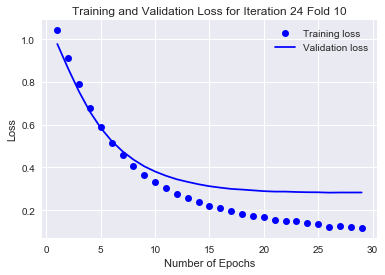

In [8]:
# Pass in a metric (without the `val_` prefix) and a fold index to show
# the training and validation error curves over the number of epochs
display_metric_vs_epochs_plot(iter_fold_scores, 'loss', nth_iter, nth_fold)

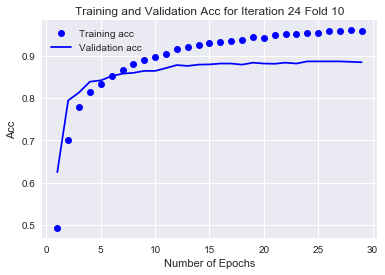

In [9]:
display_metric_vs_epochs_plot(iter_fold_scores, 'acc', nth_iter, nth_fold)

### Make predictions on the test data
In order to make predictions on the Kaggle-provided unlabeled test data, we will need to submit our predictions to Kaggle. It would be best to train on the entire training set; this means that, this time, we won't provide a validation set to the Keras model.

How do we know how many epochs to train for? To figure this out, we can use the results from the cross validation phase. Since we have recorded the number of epochs that each fold took to train the model before stopping, we can take the average number of epochs across all folds and use that as the number of epochs to train our final model.

#### Train the model

In [24]:
# Set this to the best number of epochs based on the evaluation phase
final_num_epochs = 20

In [25]:
# Select the best model params based on the evaluation phase
best_iter = 24
final_model_params = load_dictionary_from_file(f'{OUTPUT_MODELS_DIR}'
                                               f'iter_{best_iter:02d}.params.json')
final_batch_size = final_model_params['batch_size']
print(json.dumps(final_model_params, indent=4))

{
    "batch_size": 512,
    "units": 64,
    "dropout_rate": 0.5,
    "optimizer": "rmsprop",
    "num_total_layers": 2
}


In [138]:
# Build the model with the best model params
model = build_model(input_shape, final_model_params)
# Save the model architecture, weights, and optimizer state to file
model.save(f'{OUTPUT_MODELS_DIR}final.iter_{best_iter:02d}.model.hdf5')
# Save the model summary to file
save_model_summary(model,
                   f'{OUTPUT_SUMMARIES_DIR}final.iter_{best_iter:02d}.model_summary.txt')

In [139]:
# Train the model
history = model.fit(X_train_tokenized,
                    y_train_encoded,
                    batch_size=final_batch_size,
                    epochs=final_num_epochs,
                    verbose=1,
                    shuffle=True)

Epoch 1/30
19579/19579 [==============================] - 2s 95us/step - loss: 1.0492 - acc: 0.4785
Epoch 2/30
19579/19579 [==============================] - 2s 85us/step - loss: 0.9284 - acc: 0.6588
Epoch 3/30
19579/19579 [==============================] - 2s 86us/step - loss: 0.8099 - acc: 0.7230
Epoch 4/30
19579/19579 [==============================] - 2s 86us/step - loss: 0.7096 - acc: 0.7551
Epoch 5/30
19579/19579 [==============================] - 2s 87us/step - loss: 0.6385 - acc: 0.7700
Epoch 6/30
19579/19579 [==============================] - 2s 86us/step - loss: 0.5767 - acc: 0.7913
Epoch 7/30
19579/19579 [==============================] - 2s 87us/step - loss: 0.5434 - acc: 0.7999
Epoch 8/30
19579/19579 [==============================] - 2s 86us/step - loss: 0.4989 - acc: 0.8156
Epoch 9/30
19579/19579 [==============================] - 2s 86us/step - loss: 0.4709 - acc: 0.8274
Epoch 10/30
19579/19579 [==============================] - 2s 87us/step - loss: 0.4507 - acc: 0.8333

#### Make predictions on the test data

In [140]:
predictions = model.predict(X_test_tokenized, batch_size=final_batch_size, verbose=1)

8392/8392 [==============================] - 1s 84us/step


In [141]:
# Check the final submission values
predictions[0:3]

array([[2.5614396e-02, 1.4678911e-02, 9.5970666e-01],
       [9.9765897e-01, 2.0930842e-03, 2.4802133e-04],
       [8.4291995e-03, 9.8167622e-01, 9.8946141e-03]], dtype=float32)

#### Create a submission CSV

In [142]:
submission[['EAP', 'HPL', 'MWS']] = predictions
submission_num = 37
submission_description = 'bow_mlp_iter_24_second'
submission_filename = f'{submission_num:03d}_{submission_description}.csv'
submission_file_path = f'{OUTPUT_SUBMISSIONS_DIR}{submission_filename}'
submission.to_csv(submission_file_path, index=False)

### Evaluate the mean logloss of the Kaggle submission
After submitting to Kaggle, we can calculate the mean logloss across the entire test dataset as follows:
```
Given:
    n_test = 8392
    %_private = 0.7
    %_public = 0.3
    private_logloss # Retrieve from Kaggle after submission
    public_logloss # Retrieve from Kaggle after submission
    
Mean logloss = (private_logloss * n_private + public_logloss * n_public) / n_test
             = (private_logloss * (%_private * n_test)
                + public_logloss * (%_public * n_test))
               / n_test
               
Where n_test = n_private + n_public
```

#### Benchmark Model
Our benchmark model is the sample submission file provided by Kaggle, in which the probability distribution across the three authors is the exact same per sample, such that their probabilities are proportional to the number of samples of said author's work in the training dataset (EAP at about 40%, HPL at about 29%, and MWS at about 31%).

In [37]:
n_test = len(submission)
n_private = n_test * 0.7
n_public = n_test * 0.3
print(f'Total number of samples: {n_test}',
      f'Number of private leaderboard samples: {n_private}',
      f'Number of public leaderboard samples: {n_public}',
      sep='\n')

Total number of samples: 8392
Number of private leaderboard samples: 5874.4
Number of public leaderboard samples: 2517.6


In [38]:
private_logloss = 1.09094
public_logloss = 1.08199
mean_logloss = (private_logloss * n_private + public_logloss * n_public) / n_test
print(f'Mean logloss for the benchmark model: {mean_logloss}')

Mean logloss for the benchmark model: 1.088255


#### CNN Model

In [39]:
calculate_mean_logloss(0.36698, 0.38822)

Mean logloss: 0.37335


## Results
Let's visualize the final results of all six models.

In [18]:
results_temp = pd.read_csv(f'{RESULTS_DIR}kaggle_spooky_author_submission_results.csv')
print(results_temp.shape)
results_temp.head()

(53, 8)


,test_num,private_lb_logloss,public_lb_logloss,mean_lb_logloss,ten_fold_cv_logloss,lb_cv_mean,filename,description
0,1,1.09094,1.08199,1.08825,NaN,NaN,sample_submission.csv,The sample submission benchmark model
1,2,0.51096,0.53244,0.51740,0.52041,0.51891,002_glove_best_manual_cnn_before_tp.csv,GloVe best manual CNN model before text prepro...
2,3,0.45205,0.47175,0.45796,0.44848,0.45322,003_glove_best_manual_rnn_before_tp.csv,GloVe best manual RNN model before text prepro...
3,4,0.44605,0.47341,0.45426,0.42506,0.43966,004_fasttext_best_manual_rnn_before_tp.csv,fastText best manual RNN model before text pre...
4,5,0.46585,0.50380,0.47723,0.47282,0.47503,005_fasttext_best_manual_cnn_before_tp.csv,fastText best manual CNN model before text pre...


In [19]:
def filter_tests(test_nums):
    return results['test_num'].isin(test_nums)

# We'll only visualize the initial and best-of-model models, all of which have no NaN values
test_num_order = [23, 44, 28, 46, 14, 50, 29, 53, 33, 41, 34, 37]

In [20]:
results = results_temp[results_temp['test_num'].isin(test_num_order)].drop(
    ['private_lb_logloss', 'public_lb_logloss', 'filename', 'description'],
    axis=1)

results.loc[filter_tests([23, 44, 28, 46]), 'feature'] = 'GloVe'
results.loc[filter_tests([14, 50, 29, 53]), 'feature'] = 'fastText'
results.loc[filter_tests([33, 41, 34, 37]), 'feature'] = 'BoW'

results.loc[filter_tests([23, 44, 14, 50]), 'model'] = 'CNN'
results.loc[filter_tests([28, 46, 29, 53]), 'model'] = 'RNN'
results.loc[filter_tests([33, 41, 34, 37]), 'model'] = 'MLP'

results.loc[filter_tests([23, 44, 14, 50]), 'bow_mlp_feature'] = 'Not MLP'
results.loc[filter_tests([28, 46, 29, 53]), 'bow_mlp_feature'] = 'Not MLP'
results.loc[filter_tests([33, 41]), 'bow_mlp_feature'] = '20k n-grams'
results.loc[filter_tests([34, 37]), 'bow_mlp_feature'] = 'All n-grams'

results.loc[filter_tests([23, 28, 14, 29, 33, 34]), 'solution'] = 'initial'
results.loc[filter_tests([44, 46, 50, 53, 41, 37]), 'solution'] = 'best-of-model'
results.loc[filter_tests([37]), 'solution'] = 'final-best'

results

,test_num,mean_lb_logloss,ten_fold_cv_logloss,lb_cv_mean,feature,model,bow_mlp_feature,solution
13,14,0.43710,0.43531,0.43621,fastText,CNN,Not MLP,initial
22,23,0.46028,0.47104,0.46566,GloVe,CNN,Not MLP,initial
27,28,0.41285,0.40661,0.40973,GloVe,RNN,Not MLP,initial
28,29,0.40828,0.37966,0.39397,fastText,RNN,Not MLP,initial
32,33,0.36098,0.35602,0.35850,BoW,MLP,20k n-grams,initial
33,34,0.34003,0.30814,0.32409,BoW,MLP,All n-grams,initial
36,37,0.30494,0.30108,0.30301,BoW,MLP,All n-grams,final-best
40,41,0.34145,0.34165,0.34155,BoW,MLP,20k n-grams,best-of-model
43,44,0.48029,0.46342,0.47186,GloVe,CNN,Not MLP,best-of-model
45,46,0.40793,0.39675,0.40234,GloVe,RNN,Not MLP,best-of-model


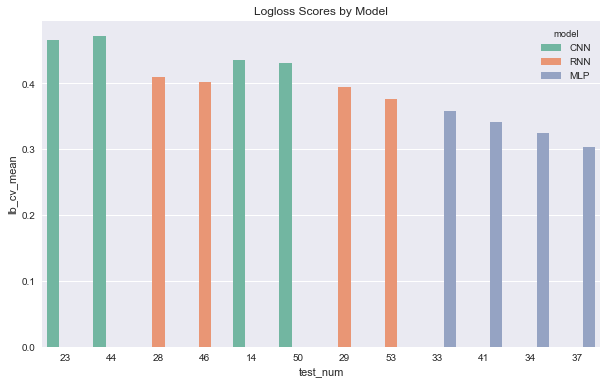

In [21]:
fig, ax = plt.subplots(figsize=(10,6))
scores_by_model_plot = sns.barplot(x='test_num',
                                   y='lb_cv_mean',
                                   hue='model',
                                   data=results,
                                   ax=ax,
                                   order=test_num_order,
                                   palette='Set2').set_title(
                                       'Logloss Scores by Model')

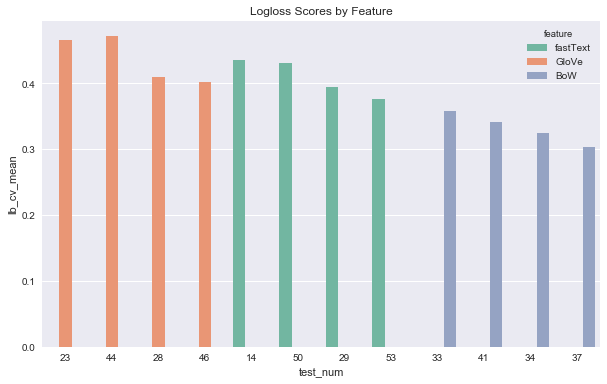

In [22]:
fig, ax = plt.subplots(figsize=(10,6))
scores_by_feature_plot = sns.barplot(x='test_num',
                                     y='lb_cv_mean',
                                     hue='feature',
                                     data=results,
                                     ax=ax,
                                     order=test_num_order,
                                     palette='Set2').set_title(
                                         'Logloss Scores by Feature')

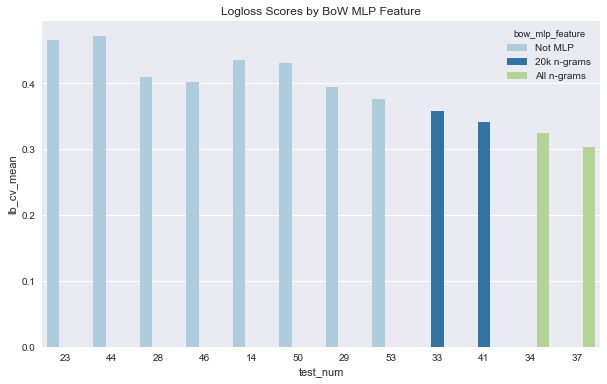

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
scores_by_bow_mlp_feature_plot = sns.barplot(x='test_num',
                                             y='lb_cv_mean',
                                             hue='bow_mlp_feature',
                                             data=results,
                                             ax=ax,
                                             order=test_num_order,
                                             palette='Paired').set_title(
                                                 'Logloss Scores by BoW MLP Feature')

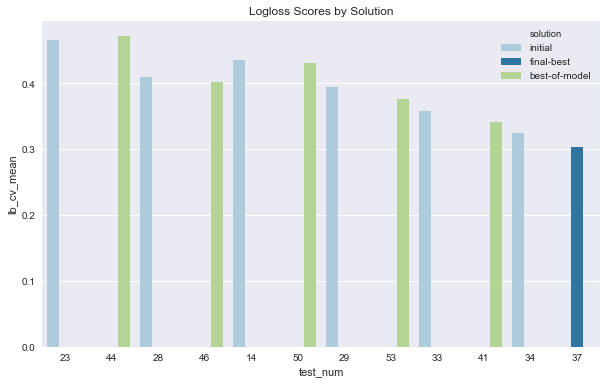

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
scores_by_solution_plot = sns.barplot(x='test_num',
                                      y='lb_cv_mean',
                                      hue='solution',
                                      data=results,
                                      ax=ax,
                                      order=test_num_order,
                                      palette='Paired').set_title(
                                          'Logloss Scores by Solution')

In [25]:
scores_by_model_plot.figure.savefig(f'{IMAGES_DIR}scores_by_model_plot.png')
scores_by_feature_plot.figure.savefig(f'{IMAGES_DIR}scores_by_feature_plot.png')
scores_by_bow_mlp_feature_plot.figure.savefig(f'{IMAGES_DIR}scores_by_bow_mlp_feature_plot.png')
scores_by_solution_plot.figure.savefig(f'{IMAGES_DIR}scores_by_solution_plot.png')